In [68]:
%cd /content/drive/MyDrive/0Thiland Coordination

/content/drive/MyDrive/0Thiland Coordination


In [69]:
!pip install geopandas
!pip install wget
!pip install rioxarray

In [3]:
import wget
import pickle
import pandas as pd

import numpy as np
import geopandas as gpd

In [4]:
import pandas as pd
import numpy as np
import pickle
import os
import tarfile
import xarray
from matplotlib import pyplot as plt
from sklearn import  metrics
from scipy.cluster.hierarchy import dendrogram

import rioxarray as xr
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


## Utils


In [5]:
def cluster_with_kmeans(df,n=5):
  kmeans = KMeans(n_clusters=n,max_iter=10000,n_init=20).fit(df)

  clusters_dict={}
  l=kmeans.labels_
  for i,c in enumerate(l):
    if c in clusters_dict:
      clusters_dict[c].append(i)
    else:
      clusters_dict[c]=[i,]

  clusters_dict_names={}
  for k in clusters_dict:
    clusters_dict_names[k]=[]
    for city_idx in clusters_dict[k]:
      clusters_dict_names[k].append(idx_name[city_idx])
  
  return clusters_dict_names,l


def agg_clustering(df,n=5,link='ward'):
  AC=AgglomerativeClustering(n_clusters=n,linkage=link).fit(df)
  clusters_dict={}
  l=AC.labels_
  for i,c in enumerate(l):
    if c in clusters_dict:
      clusters_dict[c].append(i)
    else:
      clusters_dict[c]=[i,]

  clusters_dict_names={}
  for k in clusters_dict:
    clusters_dict_names[k]=[]
    for city_idx in clusters_dict[k]:
      clusters_dict_names[k].append(idx_name[city_idx])
  
  return AC,clusters_dict_names,l


def viz_clusters(df,clusters_dict_names,inc_names=False):

  plt.figure(figsize=(10,10))  
  for c in clusters_dict_names.keys():
    cities=clusters_dict_names[c]
    inds=[]
    for city in cities:
      inds.append(name_idx[city])
    

    
    pts=df[inds]
    plt.scatter(pts[:,0],pts[:,1])
    _avg=np.mean(pts,axis=0)
    plt.annotate(c,(_avg[0],_avg[1]))


  v=[clusters_dict_names[k][0] for k in clusters_dict_names.keys()]  
  plt.legend(v)  
  plt.show()

  if inc_names:
    plt.figure(figsize=(30,20))
    for c in clusters_dict_names.keys():
      cities=clusters_dict_names[c]
      inds=[]
      for city in cities:
        inds.append(name_idx[city])
      

      
      pts=df[inds]
      plt.scatter(pts[:,0],pts[:,1])
      for ind in inds:
        plt.text(df[ind,0],df[ind,1],idx_name[ind],fontsize=15)
    
    plt.show()

    

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def evaluate_clustering(df,labels):
  return metrics.silhouette_score(df, labels, metric='euclidean'),metrics.calinski_harabasz_score(df, labels)

def get_clus_dist(dict_clus):
  c_num={}
  n=len(dict_clus)
  for k in dict_clus:
    c_num[k]=len(dict_clus[k])
  
  plt.bar(list(range(n)),c_num)
  return c_num

# new_all_cities_file = os.path.join("GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0", "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
# new_all_cities_gdf = gpd.read_file(new_all_cities_file)
# new_all_cities_gdf_filterd_2=new_all_cities_gdf[new_all_cities_gdf['FUA_p_2015'] > 5000000 ]


## Gather All data

In [ ]:
new_all_cities_file = os.path.join("GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0", "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
new_all_cities_gdf = gpd.read_file(new_all_cities_file)
new_all_cities_gdf_filterd_2=new_all_cities_gdf
new_all_cities_gdf_filterd_2.drop_duplicates('eFUA_name',inplace=True)
new_all_cities_gdf_filterd_2.sort_values('FUA_p_2015',ascending=False,inplace=True)

In [ ]:
## Handle area dict
area_dict=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/Built Up data/all_area_dict.pickle','rb'))
area_dict_re={}
for k in area_dict:
  area_dict_re[k]=np.array(area_dict[k][0][1:])/255.0
area_df=pd.DataFrame.from_dict(area_dict_re,orient='index',columns=['1990_area','2000_area','2015_area','water'])
area_df.shape

(8624, 4)

In [ ]:
## Handle population
pop_df=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/Population/population_df_all.pickle','rb'))
pop_df.loc[['Tokyo','Shanghai','Quezon City [Manila]'],:]

1990_Pop      2000_Pop      2015_Pop
Tokyo                 3.040421e+07  3.320052e+07  3.647113e+07
Shanghai              1.151557e+07  1.673437e+07  2.691996e+07
Quezon City [Manila]  1.380174e+07  1.892948e+07  2.495837e+07

In [ ]:
## Handle city light
dgf=gpd.read_file('/content/drive/MyDrive/0Thiland Coordination/CSV Datasets/cities_pop_light.geojson')
clnames=['eFUA_name','geometry','CL2014',	'CL2013',	'CL2018',	'CL2016',	'CL2019',	'CL2020',	'CL2015',	'CL2017',	'CL2012']
ld=dgf.loc[:,clnames]
ld.set_index(ld.eFUA_name,inplace=True)
ld.drop_duplicates('eFUA_name',inplace=True)
subdf=ld.loc[new_all_cities_gdf_filterd_2.eFUA_name,:]
subdf.drop(['eFUA_name','geometry'],axis=1,inplace=True)
cl_df=subdf

cl_df.shape


(8641, 9)

In [ ]:
## Handle NDVI
ndvi_dict=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/NDVI/df_allvars.pickle','rb'))
top300_2015=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/NDVI/top300_2015.pickle','rb'))
for k in top300_2015:
  
  if k in ndvi_dict:
    if len(ndvi_dict[k])<15:
      ndvi_dict[k][-3:]=top300_2015[k][:3]
      for i in range(2):
        ndvi_dict[k].append(top300_2015[k][i+3])
        

In [ ]:
ndvi_dict['Chicago']

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
  ## Handle NAVI 
ndvi_df=pd.DataFrame.from_dict(ndvi_dict, orient='index',columns=['1990_mean','1990_min','1990_max','1990_median','1990_std','2000_mean','2000_min','2000_max','2000_median','2000_std','2015_mean','2015_min','2015_max','2015_median','2015_std'])
ndvi_df.loc[['New York','Boston','Tokyo'],:]#.loc[['Tokyo','Shanghai','Quezon City [Manila]'],:]


1990_mean  1990_min  1990_max  ...  2015_max  2015_median  2015_std
New York   0.068958 -0.012726  0.228305  ...  0.241042     0.046543  0.071353
Boston     0.089412 -0.017994  0.316264  ...  0.309251     0.042623  0.090806
Tokyo      0.084040 -0.013193  0.284911  ...  0.295161     0.060920  0.079420

[3 rows x 15 columns]

In [ ]:
ndvi_df.dropna(inplace=True)
ndvi_df.shape

(8624, 15)

In [ ]:
ndvi_df.loc[['Boston','Tokyo'],:]

1990_mean  1990_min  1990_max  ...  2015_max  2015_median  2015_std
Boston   0.089412 -0.017994  0.316264  ...  0.309251     0.042623  0.090806
Tokyo    0.084040 -0.013193  0.284911  ...  0.295161     0.060920  0.079420

[2 rows x 15 columns]

In [ ]:
## Concatenate all
# pop_df_sub=pop_df.loc[list(ndvi_df.index),:]
ndind=list(ndvi_df.index)
popind=list(pop_df.index)
areaind=list(area_df.index)
clind=list(cl_df.index)
jointind=[]
for ind in ndind:
  if ind in popind and ind in areaind and ind in clind:
    jointind.append(ind)

len(jointind)

8624

In [ ]:
ndvi_df['1990_range']=ndvi_df['1990_max']-ndvi_df['1990_min']
ndvi_df['2000_range']=ndvi_df['2000_max']-ndvi_df['2000_min']
ndvi_df['2015_range']=ndvi_df['2015_max']-ndvi_df['2015_min']
ndvi_df.drop(['1990_max','2000_max','2015_max','1990_min','2000_min','2015_min'],axis=1,inplace=True)

In [ ]:
## Concatenate all
pop_df_sub=pop_df.loc[jointind,:]
area_df_sub=area_df.loc[jointind,:]
ndvi_df_sub=ndvi_df.loc[jointind,:]
cl_df_sub=cl_df.loc[jointind,:]
all_df=pd.concat([area_df_sub,pop_df_sub,cl_df_sub,ndvi_df_sub],axis=1)

In [ ]:
## SAve data up to NDVI
pickle.dump(all_df,open('/content/drive/MyDrive/0Thiland Coordination/all_data_8k.pickle','wb'))

In [ ]:
# load data up to ndvi
all_data_sofar=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/all_data_8k.pickle','rb'))
all_data_sofar.shape

(8048, 28)

In [ ]:
## Handle Soil Temp.

st_df=pd.read_csv('/content/drive/MyDrive/0Thiland Coordination/CSV Datasets/soil_temp.csv')
st_df.drop_duplicates('eFUA_name',inplace=True)
st_df.drop(['eFUA_ID','Cntry_name'],inplace=True,axis=1)
st_df.set_index('eFUA_name',inplace=True)
st_filtered=st_df.loc[all_df.index,:]
all_df_with_st=pd.concat([all_df,st_filtered],axis=1)
all_df_with_st.shape

(8624, 34)

In [ ]:
## SAve data up to soil temp
pickle.dump(all_df_with_st,open('/content/drive/MyDrive/0Thiland Coordination/all_data_with_st_nonvi.pickle','wb'))

### Get City Light Data.

In [ ]:
wget.download('https://mit.enterprise.slack.com/files/W010AAUKX0V/F0264JV3X34/cities_pop_light.geojson')

In [ ]:
dgf.columns

Index(['eFUA_ID', 'UC_num', 'UC_IDs', 'eFUA_name', 'Commuting', 'Cntry_ISO',
       'Cntry_name', 'FUA_area', 'UC_area', 'FUA_p_2015', 'UC_p_2015',
       'Com_p_2015', 'pop1975', 'pop1990', 'pop2000', 'pop2015', 'CL2014',
       'CL2013', 'CL2018', 'CL2016', 'CL2019', 'CL2020', 'CL2015', 'CL2017',
       'CL2012', 'geometry'],
      dtype='object')

In [ ]:
dgf=gpd.read_file('/content/drive/MyDrive/0Thiland Coordination/cities_pop_light.geojson')

In [ ]:
dgf.drop_duplicates(['eFUA_name','geometry'],inplace=True)

In [ ]:
clnames=['eFUA_name','geometry','CL2014',	'CL2013',	'CL2018',	'CL2016',	'CL2019',	'CL2020',	'CL2015',	'CL2017',	'CL2012']
ld=dgf.loc[:,clnames]

In [ ]:
alldf=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/pickle_files/all_df.pickle','rb'))

In [ ]:
inds=alldf.index
ld.index=ld.eFUA_name
ld_100=ld.loc[alldf.index,:]
ld_100.drop_duplicates('eFUA_name',inplace=True)
all_df_jn=alldf.loc[ld_100.index,:]

In [ ]:
all_df_jn['name']=all_df_jn.index.values

In [ ]:
all_df_jn.drop_duplicates('name',inplace=True)

In [ ]:
df_all_cl=pd.concat([all_df_jn,ld_100],axis=1)

In [ ]:
df_all_cl.drop(['geometry','eFUA_name','name'],axis=1,inplace=True)

In [ ]:
df_all_cl.drop(df_all_cl.columns[5:8],axis=1,inplace=True)

In [ ]:
pickle.dump(df_all_cl,open('/content/drive/MyDrive/0Thiland Coordination/pickle_files/nondvi_withcity_lights.pkl','wb'))

In [ ]:
df_all_cl

1975      1990  ...         CL2017         CL2012
eFUA_name                             ...                              
Kabul             0.067514  0.123678  ...   24830.974609   21753.740234
Algiers           0.109881  0.168286  ...  251303.125000  170511.031250
Luanda            0.167347  0.190350  ...  129818.054688   78857.820312
Buenos Aires      0.190471  0.224297  ...  886953.000000  799542.375000
Melbourne         0.123026  0.157770  ...  232963.921875  187712.062500
...                    ...       ...  ...            ...            ...
Hanoi             0.066864  0.095819  ...   86372.820312   30289.898438
Ho Chi Minh City  0.114473  0.143462  ...  144433.093750   11296.859375
Sana'a            0.015430  0.049908  ...    3262.648682   32191.292969
Lusaka            0.108847  0.125075  ...   43420.375000   38102.164062
Harare            0.056863  0.104720  ...   23730.835938   27110.273438

[305 rows x 17 columns]

## try without vae

In [15]:
df_nondvi=pd.read_csv('/content/drive/MyDrive/0Thiland Coordination/CSV Datasets/Soc_econ_data_4paper.csv')
df_nondvi.set_index('eFUA_name',inplace=True)
X=df_nondvi.values
rows,cols=X.shape

X_scaled=((df_nondvi-df_nondvi.mean())/df_nondvi.std()).values
X_scaled.mean(axis=0)


array([ 3.34022883e-16,  2.77801209e-16, -2.64572580e-16,  1.58743548e-16,
        7.82142690e-16, -2.76974420e-16, -7.49732549e-15,  4.24969707e-15,
       -3.03266320e-15])

In [20]:
from sklearn.cluster import AgglomerativeClustering,KMeans

In [21]:
ag=AgglomerativeClustering(n_clusters=8)
ag.fit(X_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8)

In [22]:
cls_scr_sc={}
cls_scr_r={}

for n_c in range(3,10):
  ag=AgglomerativeClustering(n_clusters=n_c,linkage='ward')
  ag.fit(X_scaled)
  r=evaluate_clustering(X_scaled,ag.labels_)
  print(r)
  x,y=np.unique(ag.labels_,return_counts=True)
  print(y)
  cls_scr_sc[n_c]=r[-1]
  cls_scr_r[n_c]=r[0]

(0.4391533298152986, 5103.2184500861695)
[3690   58 4846]
(0.46188690138476196, 4576.634117521471)
[  58 3156 4846  534]
(0.4624586230670999, 4631.982844060932)
[3156   55 4846  534    3]
(0.4288705056945571, 4587.005136763708)
[  55  534 4846 2607    3  549]
(0.429412019250658, 4678.950090702096)
[  42  534 4846 2607    3  549   13]
(0.430405309262051, 4803.049635288772)
[4846  534   16 2607    3  549   13   26]
(0.30725321516283427, 4801.369556068558)
[ 534 2607   16 2712    3  549   13   26 2134]


In [ ]:
x,y=np.unique(ag.labels_,return_counts=True)

<BarContainer object of 4 artists>

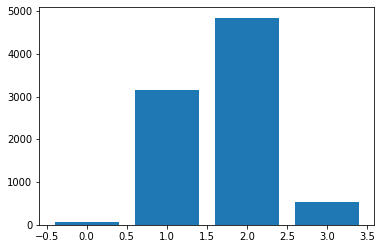

In [23]:
# cluster dis
plt.bar([0,1,2,3],[  58,3156,4846,534])

In [24]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d=ts.fit_transform(X_scaled)


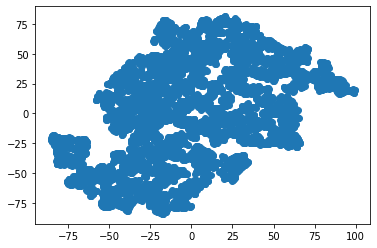

In [25]:
import matplotlib.pyplot as plt
plt.scatter(X_2d[:,0],X_2d[:,1])

In [26]:
idx_name={i:name for i,name in enumerate(df_nondvi.index)}
name_idx={name:i for i,name in enumerate(df_nondvi.index)}

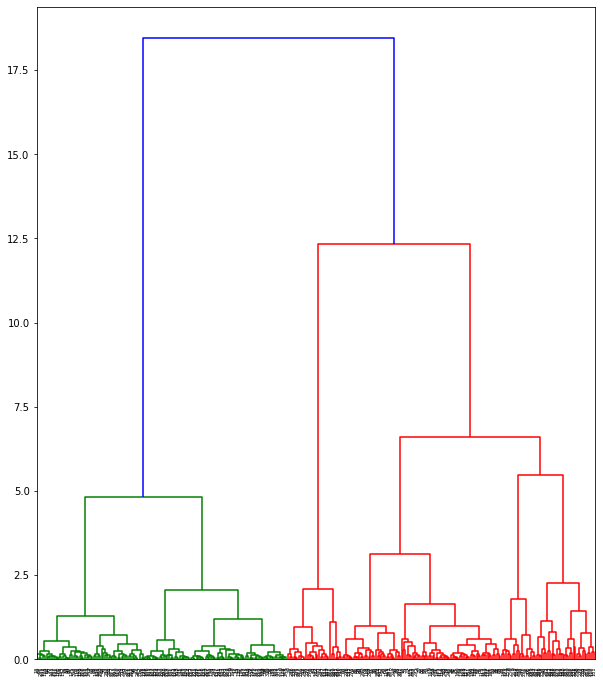

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_enc,'ward')

labelList = range(len(X_enc))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [27]:
ag_model,clus_names,clus,=agg_clustering(X_scaled,4)

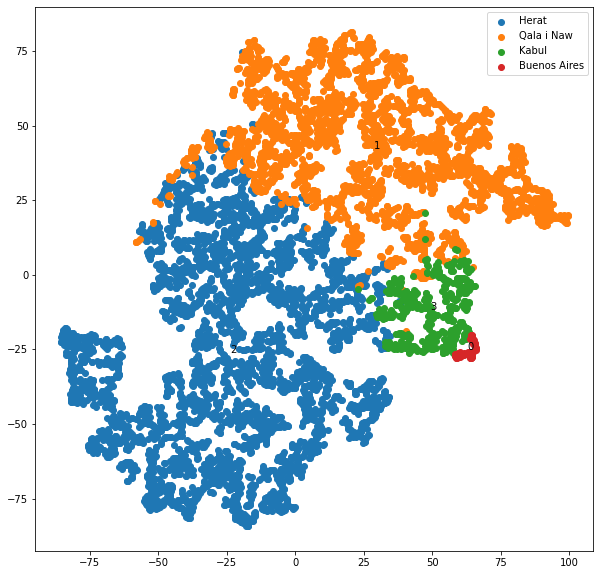

In [28]:
viz_clusters(X_2d,clus_names)

# Try AEs

## Try A Shallow Autoencoder

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Input, BatchNormalization

In [ ]:
df_nondvi=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/pickle_files/nondvi_withcity_lights.pkl','rb'))

In [ ]:
X=df_nondvi.values
rows,cols=X.shape

In [ ]:
latent_dim=5
ins=Input(shape=(cols,))
indec=Input(shape=(latent_dim,))
def encoder(inputs):
  x=Dense(100,activation='relu')(inputs)
  # x=Dense(100,activation='relu')(x)
  x=BatchNormalization()(x)
  x=Dense(int(cols//2),activation='relu')(x)
  x=BatchNormalization()(x)

  x=Dense(latent_dim,activation='relu')(x)
  
  enc_model=tf.keras.models.Model(inputs,x,name='ae_enc')
  return enc_model

def decoder(inputs):
  x=Dense(int(cols//2),activation='relu')(inputs)
  # x=Dense(200,activation='relu')(x)
  x=BatchNormalization()(x)

  x=Dense(100,activation='relu')(x)
  x=BatchNormalization()(x)

  x=Dense(cols,activation='tanh')(x)

  dec_model=tf.keras.models.Model(inputs,x,name='dec_model')
  return dec_model


  

In [ ]:
enc_model=encoder(ins)
enc_out=enc_model(ins)
dec_model=decoder(indec)
dec_out=dec_model(enc_out)
ae_model=tf.keras.models.Model(ins,dec_out,name='ae')

In [ ]:
ae_model.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 17)]              0         
_________________________________________________________________
ae_enc (Functional)          (None, 5)                 3085      
_________________________________________________________________
dec_model (Functional)       (None, 17)                3097      
Total params: 6,182
Trainable params: 5,750
Non-trainable params: 432
_________________________________________________________________


In [ ]:
ae_model.compile(optimizer='adam',loss='mse',metrics=['mse'])


In [ ]:
X_scaled=((df_nondvi-df_nondvi.mean())/df_nondvi.std()).values
X_scaled.mean(axis=0)

array([-5.00874388e-16,  5.24170871e-16, -8.85266359e-16, -2.21316590e-16,
       -6.69773890e-17, -1.80547744e-16, -2.73733677e-16,  2.64997496e-16,
        6.98894494e-17, -2.32964831e-17, -2.32964831e-17, -2.32964831e-17,
        4.65929663e-17, -6.98894494e-17, -2.32964831e-17,  0.00000000e+00,
       -3.49447247e-17])

In [ ]:
es_callback=tf.keras.callbacks.EarlyStopping(patience=10)
his=ae_model.fit(X_scaled,X_scaled,epochs=200,batch_size=8,validation_split=0.2,callbacks=[es_callback])

Epoch 1/200
31/31 [==============================] - 2s 10ms/step - loss: 1.1213 - mse: 1.1213 - val_loss: 1.7670 - val_mse: 1.7670
Epoch 2/200
31/31 [==============================] - 0s 4ms/step - loss: 0.8060 - mse: 0.8060 - val_loss: 1.7542 - val_mse: 1.7542
Epoch 3/200
31/31 [==============================] - 0s 4ms/step - loss: 0.6519 - mse: 0.6519 - val_loss: 1.6687 - val_mse: 1.6687
Epoch 4/200
31/31 [==============================] - 0s 4ms/step - loss: 0.6384 - mse: 0.6384 - val_loss: 1.6121 - val_mse: 1.6121
Epoch 5/200
31/31 [==============================] - 0s 4ms/step - loss: 0.5570 - mse: 0.5570 - val_loss: 1.4631 - val_mse: 1.4631
Epoch 6/200
31/31 [==============================] - 0s 4ms/step - loss: 0.5398 - mse: 0.5398 - val_loss: 1.3217 - val_mse: 1.3217
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 0.5023 - mse: 0.5023 - val_loss: 1.2307 - val_mse: 1.2307
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 0.4678 - 

In [ ]:
X_enc=enc_model(X_scaled)

In [ ]:
tf.reduce_mean(X_enc,axis=0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.39276075, 1.0094808 , 0.6785021 , 0.66469705, 0.5365804 ],
      dtype=float32)>

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d_ae=ts.fit_transform(X_enc_ae)


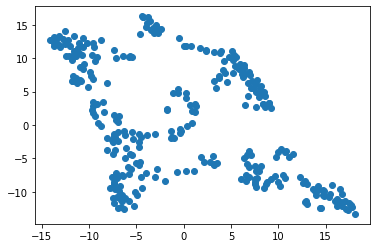

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_2d[:,0],X_2d[:,1])

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
ag=AgglomerativeClustering(n_clusters=4)
ag.fit(X_enc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [ ]:
evaluate_clustering(X_enc,ag.labels_)

(0.3306286, 154.25510684777362)

In [ ]:
np.unique(ag.labels_,return_counts=True)

(array([0, 1, 2, 3]), array([90, 87, 31, 97]))

In [ ]:
idx_name={i:name for i,name in enumerate(df_nondvi.index)}
name_idx={name:i for i,name in enumerate(df_nondvi.index)}

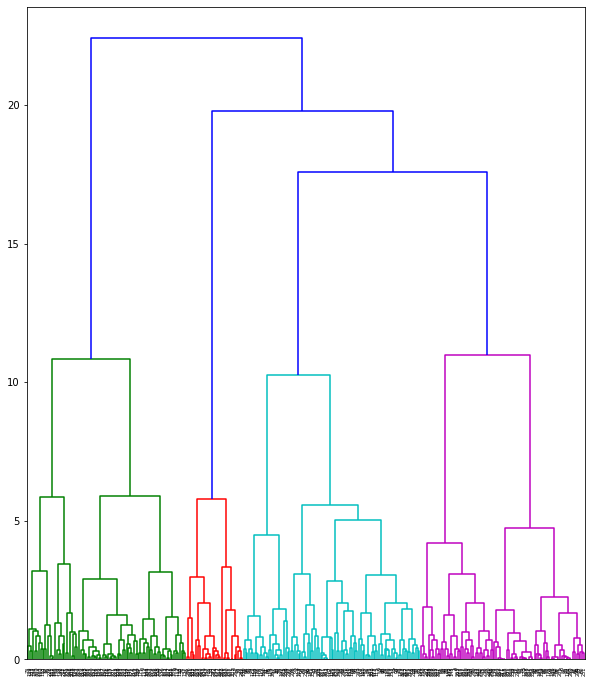

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_enc,'ward')

labelList = range(len(X_enc))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
ae_model.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/ae_model_300_novi.h5')

In [ ]:
enc_model.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/enc_model_300_novi.h5')

In [ ]:
ae_model=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/ae_model_300_novi.h5')
enc_model=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/enc_model_300_novi.h5')

In [ ]:
X_enc_ae=enc_model(X_scaled)
ag_model,clus_names,clus,=agg_clustering(X_enc_ae,4)

In [ ]:
clus_names

{0: ['Algiers',
  'Melbourne',
  'Sydney',
  'Baku',
  'Manaus',
  'Belém',
  'Porto Alegre',
  'Belo Horizonte',
  'Salvador',
  'Recife',
  'Douala',
  'Vancouver',
  'Montreal',
  'Santiago',
  'Chengdu',
  'Kunming',
  'Chongqing',
  'Binhai',
  'Dalian',
  'Wuhan',
  'Yantai',
  'Nanjing',
  'Hangzhou',
  'Jieyang',
  'Ningbo',
  'Xiamen',
  'Fuzhou',
  'Quanzhou',
  'Wenzhou',
  'Bogota',
  'Havana',
  'Abidjan',
  'Santo Domingo',
  'Guayaquil',
  'Alexandria',
  'Mansoura',
  'Dortmund',
  'Athens',
  'Conakry',
  'Port-au-Prince',
  'Hyderabad',
  'Bengaluru',
  'Denpasar',
  'Baghdad',
  'Rome',
  'Naples',
  'Fukuoka',
  'Nagoya',
  'Kuwait City',
  'Beirut',
  'Casablanca',
  'Lagos',
  'Karachi',
  'Lima',
  'Katowice',
  'Warsaw',
  'Lisbon',
  'Jeddah',
  'Dammam',
  'Singapore',
  'Cape Town',
  'Durban',
  'Busan',
  'Madrid',
  'Barcelona',
  'Stockholm',
  'Zurich',
  'New Taipei [Taipei]',
  'Kaohsiung',
  'Bangkok',
  'Lomé',
  'Tunis',
  'Izmir',
  'Istanbul',
  '

In [ ]:
df_nondvi.loc[['New York','Philadelphia','Cairo','Paris'],:]

1975      1990  ...        CL2017         CL2012
eFUA_name                         ...                             
New York      0.227583  0.264693  ...  1.250429e+06  560460.375000
Philadelphia  0.104403  0.135948  ...  6.343469e+05  276083.656250
Cairo         0.122234  0.143448  ...  6.593079e+05  656296.875000
Paris         0.181300  0.208451  ...  6.031911e+05  128127.046875

[4 rows x 17 columns]

In [ ]:
df_nondvi.loc[['New York','Vienna','Minsk','Damascus','Khartoum'],:]

1975      1990  ...        CL2017         CL2012
eFUA_name                      ...                             
New York   0.227583  0.264693  ...  1.250429e+06  560460.375000
Vienna     0.093557  0.124315  ...  1.036096e+05   14505.627930
Minsk      0.086764  0.121951  ...  9.670194e+04   35511.093750
Damascus   0.107445  0.149576  ...  3.479600e+04   77610.296875
Khartoum   0.087022  0.112125  ...  7.316383e+04   42118.230469

[5 rows x 17 columns]

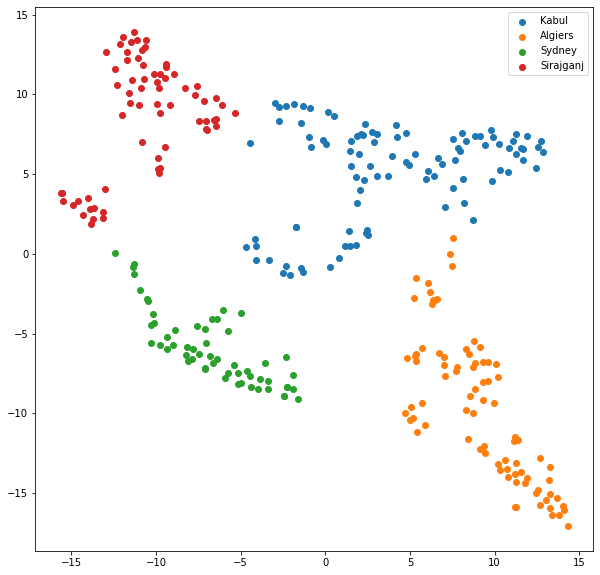

In [ ]:
ag,clus_names,k=agg_clustering(X_2d_ae,4)
# clus_names,k=cluster_with_kmeans(X_2d_ae,4)

viz_clusters(X_2d_ae,clus_names)

## Try VAE + Tanh

In [ ]:
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

In [ ]:
df_all_cl=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/pickle_files/nondvi_withcity_lights.pkl','rb'))

In [ ]:
import tensorflow as tf
keras=tf.keras
import tensorflow.keras.backend as K

In [ ]:
latent_dim=5
X=df_all_cl.values
rows,cols=X.shape

In [ ]:

class Sample(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    shapes=tf.shape(mu)
    batch=shapes[0]
    col=shapes[1]
    eps=K.random_normal((batch,col))
    Z=mu+eps*tf.exp(sigma*0.5)
    return Z

In [ ]:

def encoder_layers(inputs,latent_dim):

  
  x=keras.layers.Dense(100,activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(20,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(int(cols//2),activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  mu=keras.layers.Dense(latent_dim)(x)
  sigma=keras.layers.Dense(latent_dim)(x)

  return mu,sigma

def encoder_model(input_shape,latent_dim):

  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma=encoder_layers(inputs,latent_dim)

  Z=Sample()([mu,sigma])

  enc_model=keras.models.Model(inputs=inputs,outputs=[mu,sigma,Z])

  return enc_model






In [ ]:
encoder=encoder_model(cols,latent_dim)

In [ ]:
def decoder_layers(inputs):
  x=keras.layers.Dense(int(cols//2),activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)

  x=keras.layers.Dense(20,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(100,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)

  x=keras.layers.Dense(cols,activation='tanh')(x)

  return x


def decoder_model(latent_dim):
  inputs=keras.layers.Input(shape=latent_dim)
  outpus=decoder_layers(inputs)

  dec_model=keras.models.Model(inputs,outpus)
  return dec_model



In [ ]:
decoder=decoder_model(latent_dim)

In [ ]:
decoder.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_177 (Dense)            (None, 8)                 48        
_________________________________________________________________
batch_normalization_111 (Bat (None, 8)                 32        
_________________________________________________________________
dense_178 (Dense)            (None, 20)                180       
_________________________________________________________________
batch_normalization_112 (Bat (None, 20)                80        
_________________________________________________________________
dense_179 (Dense)            (None, 100)               2100      
_________________________________________________________________
batch_normalization_113 (Bat (None, 100)               400

In [ ]:

def KL_loss(inputs, outputs, mu, sigma):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return los+tf.reduce_mean(kl_loss) * -0.5

def mse_loss(inputs,outputs):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  return los

In [ ]:
def vae_model(input_shape,encoder,decoder):
  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma,Z=encoder(inputs)
  dec_output=decoder(Z)
  model=keras.models.Model(inputs,dec_output)
  losskl=KL_loss(inputs,dec_output,mu,sigma)
  # mse = tf.keras.losses.mean_squared_error(inputs,dec_output)#mse_loss(inputs,dec_output)
  model.add_loss(losskl)
  # model.add_loss(mse)
  return model

In [ ]:
vae=vae_model(cols,encoder,decoder)

In [ ]:
X_scaled=(X-X.mean(axis=0))/X.std(axis=0)

In [ ]:
vae.compile(optimizer='adam')

In [ ]:
hist=vae.fit(X_scaled,X_scaled,epochs=200,validation_split=0.2)

Epoch 1/200
8/8 [==============================] - 2s 36ms/step - loss: 2.3997 - val_loss: 2.0659
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 1.8965 - val_loss: 2.0654
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 1.6618 - val_loss: 2.0264
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 1.4956 - val_loss: 1.9551
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 1.3901 - val_loss: 1.9357
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 1.2704 - val_loss: 1.9058
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 1.1916 - val_loss: 1.8684
Epoch 8/200
8/8 [==============================] - 0s 6ms/step - loss: 1.1237 - val_loss: 1.8056
Epoch 9/200
8/8 [==============================] - 0s 9ms/step - loss: 1.1021 - val_loss: 1.8133
Epoch 10/200
8/8 [==============================] - 0s 7ms/step - loss: 1.0553 - val_loss: 1.7458
Epoch 11/200
8/8 [==========

In [ ]:
vae=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_model_linear_300_novi.h5',custom_objects={'Sample':Sample,'KL_loss':KL_loss})
encoder=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_tanh_300_novi.h5',custom_objects={'Sample':Sample,'KL_loss':KL_loss})

In [ ]:
X_enc,_,_=encoder(X_scaled)

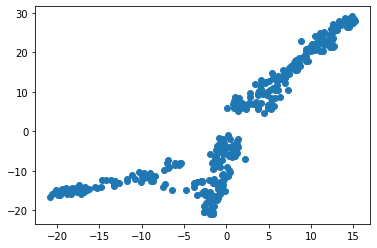

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

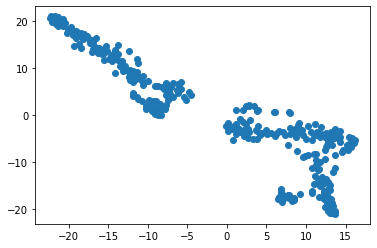

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_2d[:,0],X_2d[:,1])

In [ ]:
from sklearn.cluster import AgglomerativeClustering,KMeans

In [ ]:
ag=AgglomerativeClustering(n_clusters=3)
ag.fit(X_enc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [ ]:
evaluate_clustering(X_enc2,ag.labels_)

(0.4432243, 389.0344830995926)

In [ ]:
np.unique(ag.labels_,return_counts=True)

(array([0, 1, 2]), array([138, 137,  30]))

In [ ]:
idx_name={i:name for i,name in enumerate(df_all_cl.index)}
name_idx={name:i for i,name in enumerate(df_all_cl.index)}

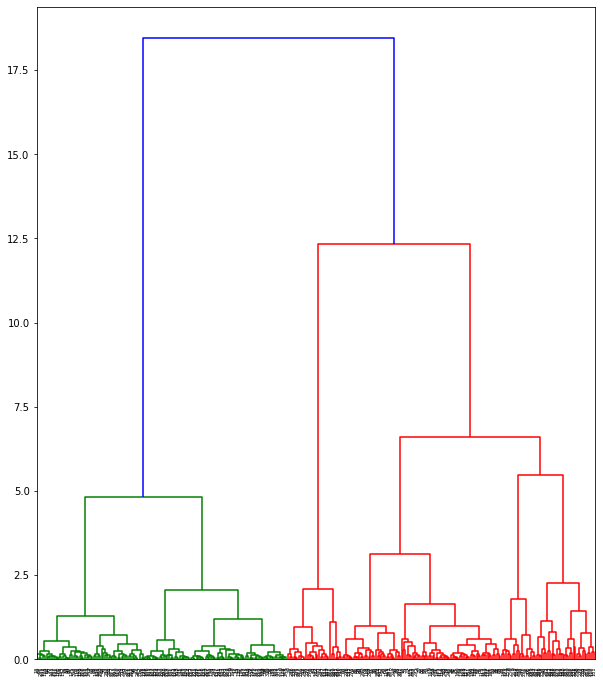

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_enc,'ward')

labelList = range(len(X_enc))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
vae.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_model_tanh_300_novi.h5')

In [ ]:
encoder.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_tanh_300_novi.h5')

In [ ]:
ag_model,clus_names,clus,=agg_clustering(X_enc,3)

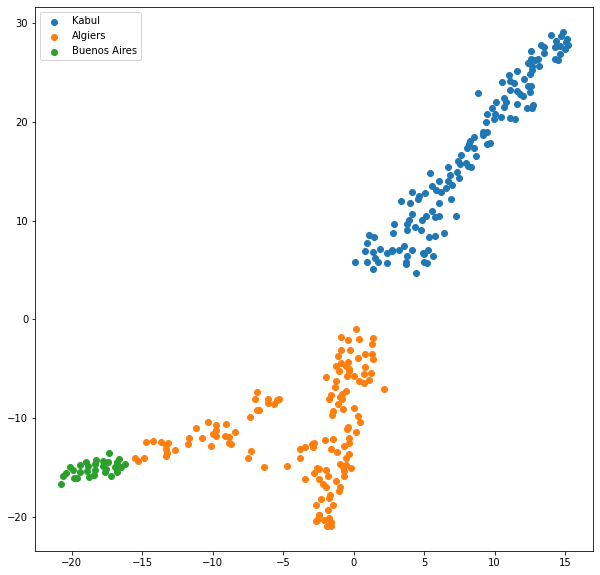

In [ ]:
viz_clusters(X_2d2,clus_names)

In [ ]:
#kmeans
clus_names,clus,=cluster_with_kmeans(X_2d2,4)

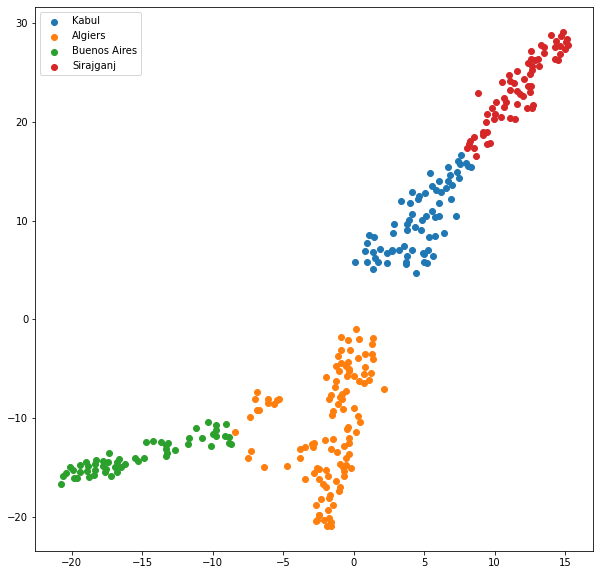

In [ ]:
viz_clusters(X_2d2,clus_names)

## Try VAE + Linear

In [ ]:
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

In [70]:
df_nondvi=pd.read_csv('/content/drive/MyDrive/0Thiland Coordination/CSV Datasets/Soc_econ_data_4paper.csv')
df_nondvi.set_index('eFUA_name',inplace=True)
X=df_nondvi.values
rows,cols=X.shape

X_scaled=((df_nondvi-df_nondvi.mean())/df_nondvi.std()).values
X_scaled.mean(axis=0)


array([ 3.34022883e-16,  2.77801209e-16, -2.64572580e-16,  1.58743548e-16,
        7.83796269e-16, -1.87681174e-16, -7.49732549e-15,  4.24638991e-15,
       -3.02935604e-15, -2.64572580e-17])

In [71]:
import tensorflow as tf
keras=tf.keras
import tensorflow.keras.backend as K

In [72]:
latent_dim=9


In [73]:

class Sample(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    shapes=tf.shape(mu)
    batch=shapes[0]
    col=shapes[1]
    eps=K.random_normal((batch,col))
    Z=mu+eps*tf.exp(sigma*0.5)
    return Z

In [74]:

def encoder_layers(inputs,latent_dim):

  ## Encoder Layers

  x=keras.layers.Dense(int(16),activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(int(8),activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  mu=keras.layers.Dense(latent_dim)(x)
  sigma=keras.layers.Dense(latent_dim)(x)

  return mu,sigma

def encoder_model(input_shape,latent_dim):

  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma=encoder_layers(inputs,latent_dim)

  Z=Sample()([mu,sigma])

  enc_model=keras.models.Model(inputs=inputs,outputs=[mu,sigma,Z])

  return enc_model






In [92]:
def decoder_layers(inputs):

  ## Decoder Layers
  x=keras.layers.Dense(6,activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(cols,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dense(cols,activation='linear')(x)

  return x


def decoder_model(latent_dim):
  inputs=keras.layers.Input(shape=latent_dim)
  outpus=decoder_layers(inputs)

  dec_model=keras.models.Model(inputs,outpus)
  return dec_model



In [93]:

def KL_loss(inputs, outputs, mu, sigma):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  # kl_loss = (1 + sigma - tf.square(mu) - tf.math.exp(sigma))* -0.5
  return kl_loss+los

def mse_loss(inputs,outputs):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  return los

In [94]:
def vae_model(input_shape,encoder,decoder):
  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma,Z=encoder(inputs)
  dec_output=decoder(Z)
  model=keras.models.Model(inputs,dec_output)
  losskl=KL_loss(inputs,dec_output,mu,sigma)
  # mse = tf.keras.losses.mean_squared_error(inputs,dec_output)#mse_loss(inputs,dec_output)
  model.add_loss(losskl)
  # model.add_loss(mse)
  return model

In [113]:
encoder=encoder_model(cols,latent_dim)
decoder=decoder_model(latent_dim)
vae=vae_model(cols,encoder,decoder)

In [114]:
vae.compile(optimizer='adam',metrics=['mse'])

In [115]:
hist=vae.fit(X_scaled,X_scaled,epochs=30)

Epoch 1/30
269/269 [==============================] - 2s 3ms/step - loss: 3.2404 - mse: 1.2391
Epoch 2/30
269/269 [==============================] - 1s 3ms/step - loss: 1.2332 - mse: 1.0309
Epoch 3/30
269/269 [==============================] - 1s 2ms/step - loss: 1.0674 - mse: 1.0097
Epoch 4/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0353 - mse: 1.0039
Epoch 5/30
269/269 [==============================] - 1s 2ms/step - loss: 1.0218 - mse: 1.0035
Epoch 6/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0116 - mse: 0.9994
Epoch 7/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0103 - mse: 1.0006
Epoch 8/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0078 - mse: 1.0012
Epoch 9/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0073 - mse: 1.0020
Epoch 10/30
269/269 [==============================] - 1s 3ms/step - loss: 1.0054 - mse: 1.0012
Epoch 11/30
269/269 [============================

In [17]:
# try loaidng the model:
# vae=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_model_linear_300_novi.h5',custom_objects=Sample)

In [116]:
X_enc,_,_=encoder(X_scaled)

In [117]:
np.std(X_enc,axis=0)


array([0.01132859, 0.01371829, 0.00454704, 0.00698515, 0.00872191,
       0.01248769, 0.0132522 , 0.00854999, 0.01095851], dtype=float32)

In [121]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

ts=TSNE(2)
X_2d=ts.fit_transform(X_enc)


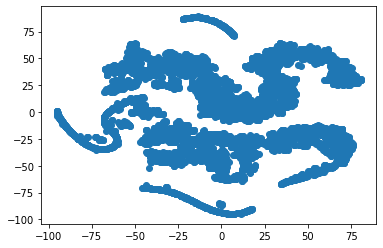

In [122]:
import matplotlib.pyplot as plt
plt.scatter(X_2d[:,0],X_2d[:,1])

In [81]:
from sklearn.cluster import AgglomerativeClustering,KMeans

In [82]:
cls_scr_sc={}
cls_scr_r={}
for n_c in range(3,10):
  ag=AgglomerativeClustering(n_clusters=n_c,linkage='ward')
  ag.fit(X_enc)
  r=evaluate_clustering(X_enc,ag.labels_)
  print(r)
  x,y=np.unique(ag.labels_,return_counts=True)
  print(y)
  cls_scr_sc[n_c]=r[-1]
  cls_scr_r[n_c]=r[0]

(0.54620254, 20249.510350088745)
[5012 1646 1936]
(0.43477395, 21483.296591602997)
[3427 1646 1936 1585]
(0.44622838, 21738.121066522905)
[1646 1585 1936 2466  961]
(0.42172128, 21262.03912124877)
[1936 1585 1146 2466  961  500]
(0.41305548, 21422.07465112735)
[1585 2466 1146 1084  961  500  852]
(0.38840896, 22386.467948237587)
[2466  498 1146 1084  961  500  852 1087]
(0.34216702, 21361.392019348623)
[1146  498 1411 1084  961  500  852 1087 1055]


In [118]:
cls_scr_sc={}
cls_scr_r={}
for n_c in range(3,10):
  ag=AgglomerativeClustering(n_clusters=n_c,linkage='ward')
  ag.fit(X_enc)
  r=evaluate_clustering(X_enc,ag.labels_)
  print(r)
  x,y=np.unique(ag.labels_,return_counts=True)
  print(y)
  cls_scr_sc[n_c]=r[-1]
  cls_scr_r[n_c]=r[0]

(0.50562817, 10686.414577639078)
[1671 2796 4127]
(0.49894997, 10525.46901394816)
[4127 2796 1429  242]
(0.42231044, 10370.311075083278)
[2796  242 1429 2554 1573]
(0.42675912, 10990.46324053974)
[1429  242 1841 2554 1573  955]
(0.41305432, 10776.36582507228)
[ 242 2554 1841  413 1573  955 1016]
(0.4162222, 10769.453221130412)
[2554  413 1841  227 1573  955 1016   15]
(0.40218288, 10531.30720947046)
[1841  413 1272  227 1573  955 1016   15 1282]


In [ ]:
evaluate_clustering(X_2d,ag.labels_)

(0.656614, 1024.0072130925923)

<BarContainer object of 6 artists>

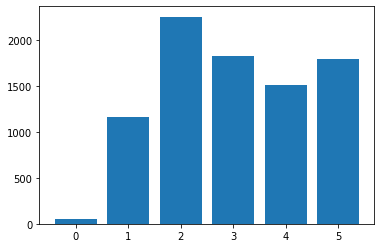

In [97]:
plt.bar([0,1,2,3,4,5],[  47, 1164, 2254, 1828, 1509, 1792])

In [89]:
idx_name={i:name for i,name in enumerate(df_nondvi.index)}
name_idx={name:i for i,name in enumerate(df_nondvi.index)}

In [88]:
df_nondvi.describe().iloc[1:,].to_csv('soc_econ_data_stats.csv')

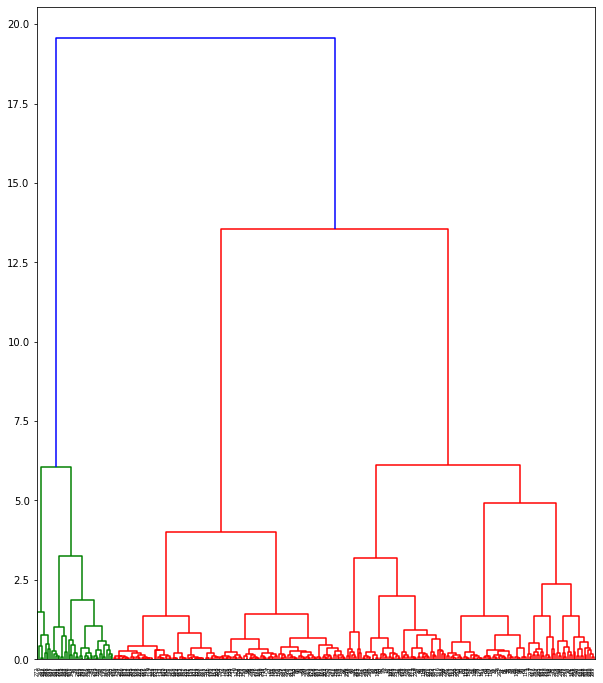

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_enc,'ward')

labelList = range(len(X_enc))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [119]:
vae.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_model_linear_soc-econ-v2.h5')

In [120]:
encoder.save('/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_model_linear_soc-econ-v2.h5')

In [123]:
ag_model,clus_names,clus,=agg_clustering(X_enc,6)

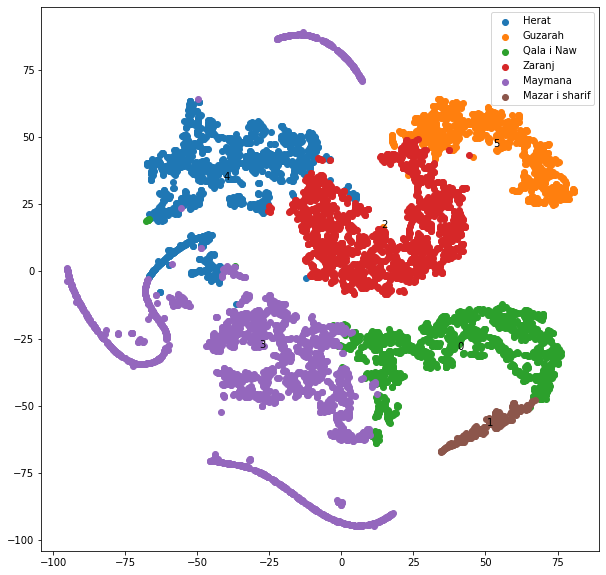

In [124]:
viz_clusters(X_2d,clus_names)

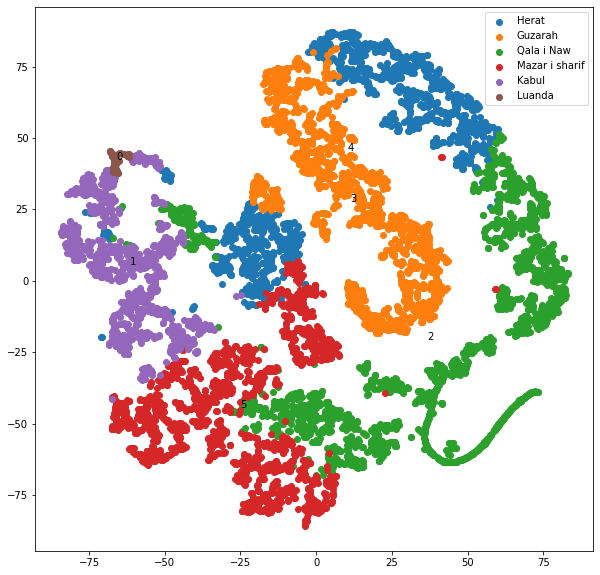

In [93]:
viz_clusters(X_2d,clus_names)

In [ ]:
#kmeans
clus_names,clus,=cluster_with_kmeans(X_enc,2)

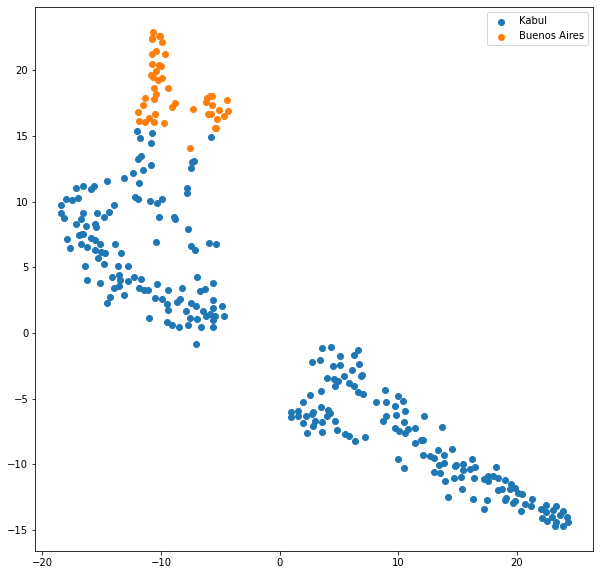

In [ ]:
viz_clusters(X_2d,clus_names)

>

## Try VAE High latent dim (up to soil temp)

In [ ]:
# tf.compat.v1.enable_eager_execution()
# tf.executing_eagerly()

In [ ]:
df_all_cl=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/all_data_with_st_8k.pickle','rb'))

In [ ]:
import tensorflow as tf
keras=tf.keras
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [ ]:
df_all_cl.dropna(inplace=True)
X=df_all_cl.values
X_scaled=(X-X.mean(axis=0))/X.std(axis=0)
rows,cols=X.shape
latent_dim=int(cols*0.75)

In [ ]:
X_scaled.shape

(8025, 46)

In [ ]:
X_tr,X_val=train_test_split(X_scaled,test_size=0.2)

In [ ]:

class Sample(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    shapes=tf.shape(mu)
    batch=shapes[0]
    col=shapes[1]
    eps=K.random_normal((batch,col))
    Z=mu+eps*tf.exp(sigma*0.5)
    return Z

In [ ]:

def encoder_layers(inputs,latent_dim):

  
  x=keras.layers.Dense(128,activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(128,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(64,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(int(64),activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  mu=keras.layers.Dense(latent_dim)(x)
  sigma=keras.layers.Dense(latent_dim)(x)

  return mu,sigma

def encoder_model(input_shape,latent_dim):

  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma=encoder_layers(inputs,latent_dim)

  Z=Sample()([mu,sigma])

  enc_model=keras.models.Model(inputs=inputs,outputs=[mu,sigma,Z])

  return enc_model






In [ ]:
def decoder_layers(inputs):

  x=keras.layers.Dense(int(32),activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(32,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(40,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(cols,activation='linear')(x)

  return x


def decoder_model(latent_dim):
  inputs=keras.layers.Input(shape=latent_dim)
  outpus=decoder_layers(inputs)

  dec_model=keras.models.Model(inputs,outpus)
  return dec_model



In [ ]:

def KL_loss(inputs, outputs, mu, sigma):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  # kl_loss = (1 + sigma - tf.square(mu) - tf.math.exp(sigma))* -0.5
  return kl_loss+los

def mse_loss(inputs,outputs):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  return los

def add_l2_regularization(layer):
    def _add_l2_regularization():
        l2 = tf.keras.regularizers.l2(1e-4)
        return l2(layer.kernel)
    return _add_l2_regularization

In [ ]:
def vae_model(input_shape,encoder,decoder):
  inputs=keras.layers.Input(shape=input_shape)
  mu,sigma,Z=encoder(inputs)
  dec_output=decoder(Z)
  model=keras.models.Model(inputs,dec_output)
  losskl=KL_loss(inputs,dec_output,mu,sigma)
  # mse = tf.keras.losses.mean_squared_error(inputs,dec_output)#mse_loss(inputs,dec_output)
  model.add_loss(losskl)
  # for i in range(len(encoder.layers)):
  #   layer = encoder.layers[i]
  #   if isinstance(layer, (tf.keras.layers.Dense)):
  #       print("added 1")
  #       model.add_loss(add_l2_regularization(layer))
  
  # for i in range(len(decoder.layers)):
  #   layer = decoder.layers[i]
  #   if isinstance(layer, (tf.keras.layers.Dense)):
  #       print("added 1")
  #       model.add_loss(add_l2_regularization(layer))
  # model.add_loss(mse)
  return model

In [ ]:
encoder=encoder_model(cols,latent_dim)
decoder=decoder_model(latent_dim)
vae=vae_model(cols,encoder,decoder)
vae.summary()


Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 46)]         0                                            
__________________________________________________________________________________________________
model_39 (Functional)           [(None, 34), (None,  40900       input_42[0][0]                   
__________________________________________________________________________________________________
model_40 (Functional)           (None, 46)           5798        model_39[0][2]                   
__________________________________________________________________________________________________
tf.__operators__.add_30 (TFOpLa (None, 34)           0           model_39[0][1]                   
___________________________________________________________________________________________

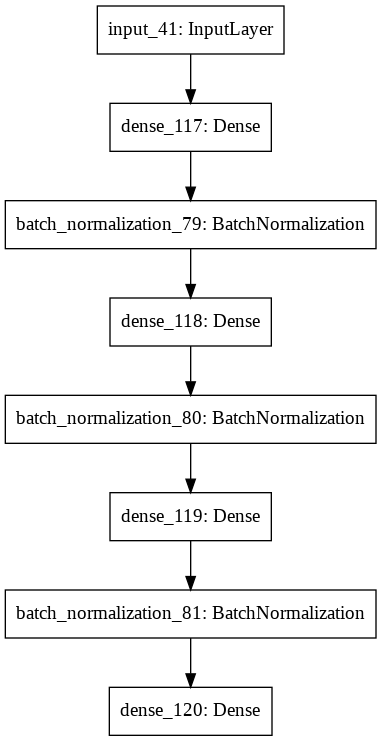

In [ ]:
keras.utils.plot_model(decoder)

In [ ]:
vae.compile(optimizer='nadam',metrics=['mse'])

In [ ]:
hist=vae.fit(X_scaled,X_scaled,epochs=100,validation_split=0.1)

Epoch 1/100
226/226 [==============================] - 6s 6ms/step - loss: 5.2544 - mse: 1.0297 - val_loss: 5.1960 - val_mse: 3.2662
Epoch 2/100
226/226 [==============================] - 1s 5ms/step - loss: 1.0020 - mse: 0.7934 - val_loss: 4.5565 - val_mse: 3.2820
Epoch 3/100
226/226 [==============================] - 1s 5ms/step - loss: 0.8587 - mse: 0.7718 - val_loss: 4.0609 - val_mse: 3.2751
Epoch 4/100
226/226 [==============================] - 1s 5ms/step - loss: 0.8151 - mse: 0.7647 - val_loss: 3.7965 - val_mse: 3.2790
Epoch 5/100
226/226 [==============================] - 1s 5ms/step - loss: 0.7966 - mse: 0.7625 - val_loss: 3.6773 - val_mse: 3.2810
Epoch 6/100
226/226 [==============================] - 1s 5ms/step - loss: 0.7847 - mse: 0.7606 - val_loss: 3.5197 - val_mse: 3.2714
Epoch 7/100
226/226 [==============================] - 1s 5ms/step - loss: 0.7778 - mse: 0.7595 - val_loss: 3.4852 - val_mse: 3.2744
Epoch 8/100
226/226 [==============================] - 1s 5ms/step - 

In [ ]:
X_enc,_,_=encoder(X_scaled)
X_dec=vae(X_scaled)

In [ ]:
tf.reduce_mean(X_enc,axis=0),tf.math.reduce_std(X_enc,axis=0)

(<tf.Tensor: shape=(34,), dtype=float32, numpy=
 array([-0.00927418, -0.00239828, -0.04268913,  0.01856497, -0.01782581,
         0.01864493, -0.00326127,  0.00258907,  0.00189182,  0.01129041,
         0.01892246, -0.00893353,  0.04617756, -0.0241905 , -0.00305787,
         0.02327444, -0.0234744 , -0.01178228, -0.01219162, -0.02149404,
        -0.00137492, -0.01981887,  0.00469094, -0.0112574 , -0.01763447,
        -0.03897062, -0.00386683,  0.0033074 , -0.04704774,  0.02860306,
         0.04666715,  0.04908036,  0.04187449,  0.03755428], dtype=float32)>,
 <tf.Tensor: shape=(34,), dtype=float32, numpy=
 array([0.10646024, 0.03745275, 0.26476339, 0.12037447, 0.16811888,
        0.1103449 , 0.04898286, 0.0461945 , 0.0396551 , 0.07220697,
        0.17224336, 0.15107335, 0.28298533, 0.20890738, 0.03589141,
        0.23177208, 0.12218542, 0.1185668 , 0.09407141, 0.18887645,
        0.06002217, 0.10744377, 0.03435526, 0.15677635, 0.09971682,
        0.29836112, 0.03872072, 0.04588896, 0.28

In [ ]:
s=tf.reduce_sum(tf.square(X_enc),axis=0)

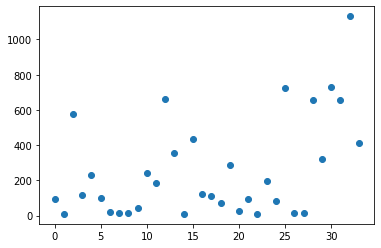

In [ ]:
plt.scatter(list(range(len(s))),s)

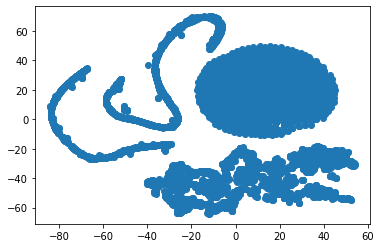

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

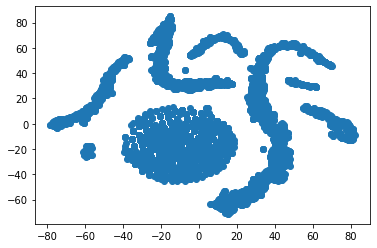

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

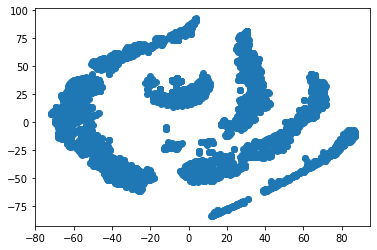

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

In [ ]:
# keras.models.save_model(vae,'/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_with_st_8k_v2.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})
# keras.models.save_model(encoder,'/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_with_st_8k_v2.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})

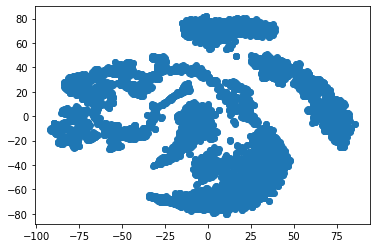

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

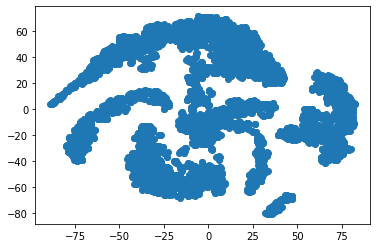

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

In [ ]:
# keras.models.save_model(vae,'/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_biglatent_linear_8k_novi.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})
# keras.models.save_model(encoder,'/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_biglatent_8k_novi.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})

In [ ]:
from sklearn.cluster import AgglomerativeClustering,KMeans,AffinityPropagation

In [ ]:
ag=AgglomerativeClustering(n_clusters=8)
ag.fit(X_2d2)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8)

In [ ]:
evaluate_clustering(X_2d2,ag.labels_)

(0.48018053, 8208.387153390551)

In [ ]:
x,y=np.unique(ag.labels_,return_counts=True)

<BarContainer object of 8 artists>

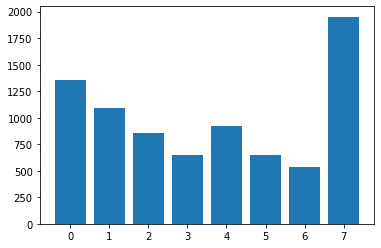

In [ ]:
#plot dis
plt.bar(x,y)

In [ ]:
idx_name={i:name for i,name in enumerate(df_all_cl.index)}
name_idx={name:i for i,name in enumerate(df_all_cl.index)}

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_2d2,'ward')

labelList = range(len(X_2d2))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
ag_model,clus_names,clus,=agg_clustering(X_2d2,8,link='single')

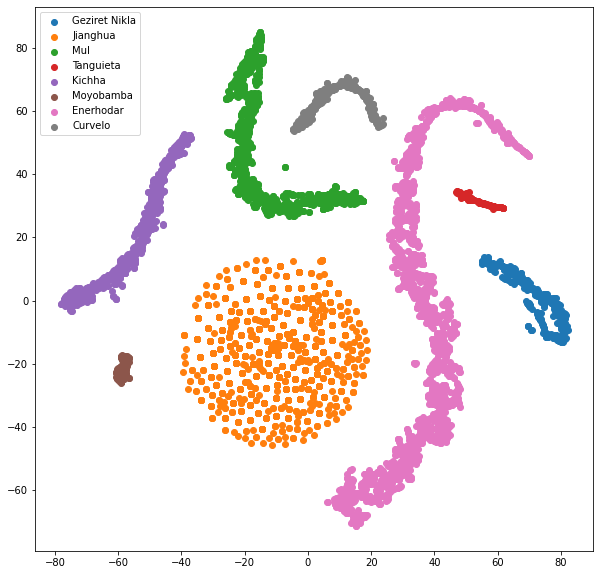

In [ ]:
viz_clusters(X_2d2,clus_names)

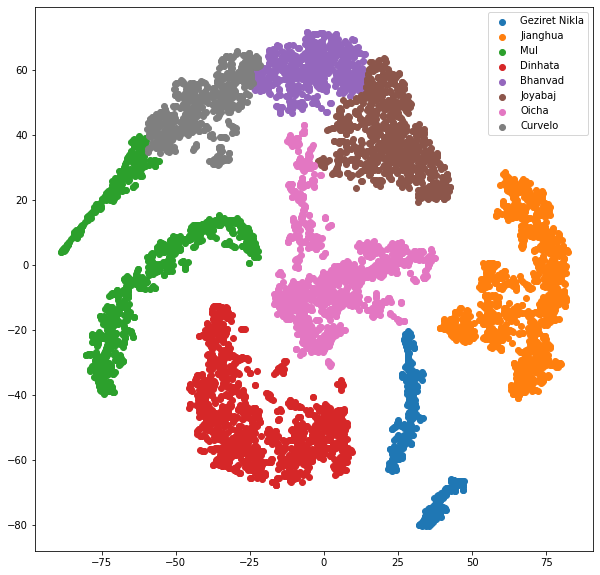

In [ ]:
viz_clusters(X_2d2,clus_names)

In [ ]:
#kmeans
clus_names,clus,=cluster_with_kmeans(X_2d2,8)

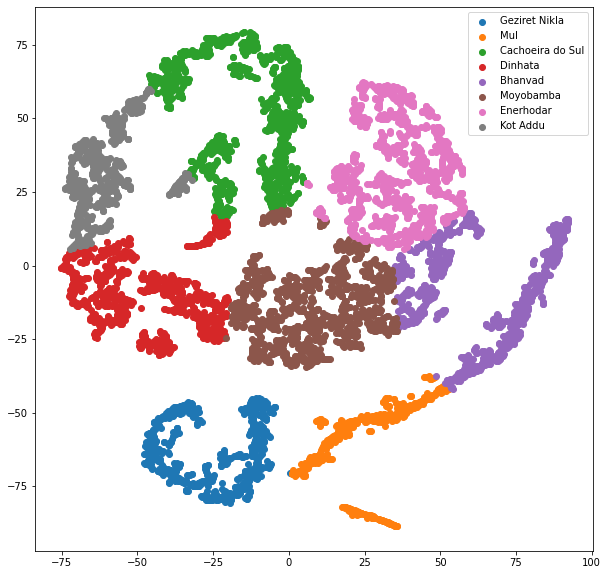

In [ ]:
viz_clusters(X_2d2,clus_names)

In [ ]:
def get_cluster_of(name,clus_dict):
  for k in clus_dict:
    if name in clus_dict[k]:
      return k

def sample_from_clusters(df,clust_dict,n_samples=2):
  samples=[]
  for k in clust_dict:
    for j in range(n_samples):
      samples.append(np.random.choice(clust_dict[k]))
  
  return df.loc[samples,:],samples

In [ ]:
get_cluster_of('New York',clus_names),get_cluster_of('Cairo',clus_names) ,get_cluster_of('Paris',clus_names) ,get_cluster_of('Minsk',clus_names),get_cluster_of('Vienna',clus_names),get_cluster_of('Khartoum',clus_names)

(2, 2, 2, 2, 2, 5)

In [ ]:
sdf,n=sample_from_clusters(df_all_cl,clus_names)
sdf

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                                ...                                
Bhongaon            0.010377   0.057711  ...       6.338884        21.348532
Solan               0.007179   0.013583  ...       5.536980        15.996277
Faris               0.085641   0.108809  ...       7.688088        22.370743
Benidorm            0.100503   0.132448  ...       7.291151        22.431362
Batouri             0.160105   0.191695  ...       1.284194         4.043477
Sonamukhi           0.167129   0.171986  ...       3.588873        12.520355
Rey Bouba           0.082544   0.099704  ...       3.387735         9.731903
Awgu                0.034519   0.041970  ...       1.749273         4.996216
Saharanpur          0.089331   0.106945  ...       6.125813        19.702723
Channapattana       0.019127   0.030094  ...       2.140322         7.136149
Nakhon Ratchasima   0.124208   0.173246  ...       2.226569         7.209368
Carpina             0.036964   0.062923  ...       1.541488         4.454979
Gilgit              0.000618   0.007711  ...       7.263806        20.684036
Fulda               0.083342   0.093130  ...       6.272441        19.348810
Hue                 0.112096   0.158683  ...       3.251033        10.763906
Tirunelveli         0.024759   0.076895  ...       2.069600         6.033099

[16 rows x 46 columns]

## Try multi input High latent dim

In [ ]:
# tf.compat.v1.enable_eager_execution()
# tf.executing_eagerly()

In [ ]:
df_all_cl=pickle.load(open('/content/drive/MyDrive/0Thiland Coordination/all_data_with_st_8k.pickle','rb'))

In [ ]:
df_all_cl.columns

Index(['1990_area', '2000_area', '2015_area', 'water', '1990_Pop', '2000_Pop',
       '2015_Pop', 'CL2014', 'CL2013', 'CL2018', 'CL2016', 'CL2019', 'CL2020',
       'CL2015', 'CL2017', 'CL2012', '1990_mean', '1990_median', '1990_std',
       '2000_mean', '2000_median', '2000_std', '2015_mean', '2015_median',
       '2015_std', '1990_range', '2000_range', '2015_range',
       'stl1_1990_average', 'stl1_1990_median', 'stl1_1990_min',
       'stl1_1990_max', 'stl1_1990_std', 'stl1_1990_range',
       'stl1_2000_average', 'stl1_2000_median', 'stl1_2000_min',
       'stl1_2000_max_x', 'stl1_2000_std', 'stl1_2000_range',
       'stl1_2015_average', 'stl1_2015_median', 'stl1_2015_min',
       'stl1_2000_max_y', 'stl1_2015_std', 'stl1_2015_range'],
      dtype='object')

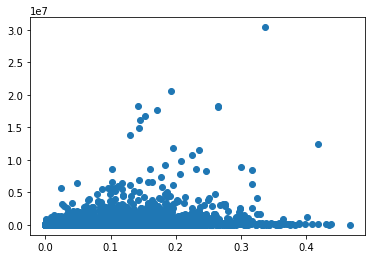

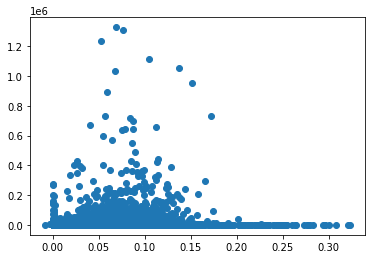

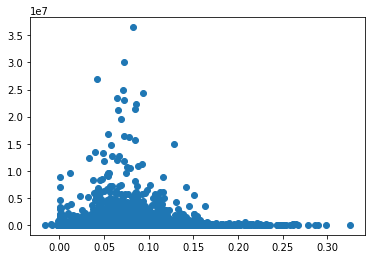

In [ ]:
plt.scatter(df_all_cl.iloc[:,[0]],df_all_cl.iloc[:,[4]])
plt.show()
plt.scatter(df_all_cl.loc[:,['1990_mean']],df_all_cl.loc[:,['CL2015']])
plt.show()
plt.scatter(df_all_cl.loc[:,['2015_mean']],df_all_cl.loc[:,['2015_Pop']])

In [ ]:
df_all_cl.corr()

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
1990_area           1.000000   0.951977  ...       0.235264         0.203927
2000_area           0.951977   1.000000  ...       0.219867         0.191956
2015_area           0.886463   0.963101  ...       0.257484         0.227400
water               0.167945   0.119007  ...      -0.103539        -0.123935
1990_Pop            0.195660   0.183904  ...       0.049153         0.046779
2000_Pop            0.192585   0.184464  ...       0.037822         0.036022
2015_Pop            0.186763   0.182718  ...       0.022989         0.021358
CL2014              0.209266   0.197735  ...       0.120259         0.115800
CL2013              0.190818   0.188679  ...       0.098550         0.096725
CL2018              0.209700   0.198802  ...       0.123423         0.117844
CL2016              0.209532   0.198108  ...       0.117585         0.112688
CL2019              0.212420   0.201413  ...       0.125341         0.119210
CL2020              0.215054   0.204778  ...       0.130123         0.123687
CL2015              0.211742   0.200251  ...       0.115123         0.110900
CL2017              0.212074   0.200862  ...       0.122055         0.116898
CL2012              0.184606   0.180967  ...       0.087628         0.085471
1990_mean           0.072551   0.065470  ...      -0.024798        -0.025972
1990_median         0.038712   0.048169  ...      -0.066356        -0.059621
1990_std            0.155926   0.115333  ...       0.091837         0.072250
2000_mean           0.071694   0.065926  ...      -0.011981        -0.007776
2000_median         0.028788   0.041569  ...      -0.052037        -0.038507
2000_std            0.154121   0.113195  ...       0.056516         0.038219
2015_mean           0.076708   0.060409  ...      -0.007799        -0.002366
2015_median         0.029202   0.034617  ...      -0.070235        -0.053976
2015_std            0.150051   0.102085  ...       0.098906         0.085525
1990_range          0.155741   0.118456  ...       0.080411         0.059960
2000_range          0.142453   0.108836  ...       0.045103         0.027212
2015_range          0.140212   0.101485  ...       0.089314         0.073913
stl1_1990_average  -0.286088  -0.229618  ...      -0.617583        -0.563423
stl1_1990_median   -0.281004  -0.224137  ...      -0.597622        -0.546420
stl1_1990_min      -0.290573  -0.247687  ...      -0.845043        -0.800668
stl1_1990_max      -0.217099  -0.155302  ...      -0.055429         0.012143
stl1_1990_std       0.213245   0.201881  ...       0.982808         0.966917
stl1_1990_range     0.203678   0.193505  ...       0.977278         0.969178
stl1_2000_average  -0.291095  -0.233178  ...      -0.597688        -0.541297
stl1_2000_median   -0.298867  -0.240353  ...      -0.548102        -0.492604
stl1_2000_min      -0.284911  -0.241691  ...      -0.845075        -0.803757
stl1_2000_max_x    -0.199350  -0.135224  ...       0.003663         0.067200
stl1_2000_std       0.215177   0.202482  ...       0.986729         0.971504
stl1_2000_range     0.200874   0.192243  ...       0.979302         0.972491
stl1_2015_average  -0.282017  -0.224061  ...      -0.615464        -0.560335
stl1_2015_median   -0.297948  -0.237004  ...      -0.568230        -0.512245
stl1_2015_min      -0.273821  -0.229165  ...      -0.857605        -0.824594
stl1_2000_max_y    -0.176681  -0.115848  ...      -0.029038         0.048425
stl1_2015_std       0.235264   0.219867  ...       1.000000         0.987249
stl1_2015_range     0.203927   0.191956  ...       0.987249         1.000000

[46 rows x 46 columns]

In [ ]:
# split data
area_cols=['1990_area', '2000_area', '2015_area', 'water']
pop_cols=['1990_Pop', '2000_Pop','2015_Pop']
cl_cols=['CL2014', 'CL2013', 'CL2018', 'CL2016', 'CL2019', 'CL2020',
       'CL2015', 'CL2017', 'CL2012']
vi_cols=['1990_mean', '1990_median', '1990_std',
       '2000_mean', '2000_median', '2000_std', '2015_mean', '2015_median',
       '2015_std', '1990_range', '2000_range', '2015_range',]

st_cols=['stl1_1990_average', 'stl1_1990_median', 'stl1_1990_std', 'stl1_1990_range',
       'stl1_2000_average', 'stl1_2000_median', 'stl1_2000_std', 'stl1_2000_range',
       'stl1_2015_average', 'stl1_2015_median', 'stl1_2015_std', 'stl1_2015_range']

area_df,pop_df,ndvi_df,cl_df,st_df=df_all_cl.loc[:,area_cols],df_all_cl.loc[:,pop_cols],df_all_cl.loc[:,vi_cols],df_all_cl.loc[:,cl_cols],df_all_cl.loc[:,st_cols]


In [ ]:
cl_df.sort_index(axis=1,inplace=True)

In [ ]:
# add pct change to area,pop,st
suf="_change"
area_df_pct=area_df.pct_change(axis='columns').drop(['1990_area','water'],axis=1)
pop_df_pct=pop_df.pct_change(axis='columns').drop([pop_df.columns[0],],axis=1)
cl_df_pct=cl_df.pct_change(axis='columns').drop([cl_df.columns[0],],axis=1)

pct_dfs={'cl_df_pct':cl_df_pct,'pop_df_pct':pop_df_pct,'area_df_pct':area_df_pct}

for df in pct_dfs.values():
  df.replace({np.nan:0,np.inf:0},inplace=True)
  
  new_cols=[]
  for col in df.columns:
    col+=suf
    new_cols.append(col)
  df.columns=new_cols

In [ ]:
pop_df=pd.concat([pop_df,pop_df_pct],axis=1)
area_df=pd.concat([area_df,area_df_pct],axis=1)
cl_df=pd.concat([cl_df,cl_df_pct],axis=1)

In [ ]:
cl_df

CL2012        CL2013  ...  CL2019_change  CL2020_change
eFUA_name                                        ...                              
Geziret Nikla          916.739502    781.936157  ...      -0.042994      -0.146272
Jianghua               254.210220    474.724060  ...       0.003317      -0.190198
Mul                     44.496361     60.335739  ...       0.285192       0.157015
Cachoeira do Sul      1828.006226   2052.903320  ...       0.069717       0.105756
Umarkhed                66.243851     88.017281  ...       0.540819      -0.151988
...                           ...           ...  ...            ...            ...
Sao Jose dos Campos  46864.972656  48700.042969  ...      -0.015822      -0.096862
Puyang               10660.084961  10952.056641  ...       0.165273       0.166671
Uyo                   1402.651123   2621.737549  ...       0.106021      -0.154046
Belfast              20798.246094      0.000000  ...      -0.126362      -0.164396
Jambi                 3783.090820   2866.486816  ...       0.434773       0.074583

[8048 rows x 17 columns]

In [ ]:
df_all_cl2=pd.concat([area_df,pop_df,ndvi_df,cl_df,st_df],axis=1)

df_all_cl2.dropna(inplace=True)

area_df.dropna(inplace=True)

pop_df.dropna(inplace=True)
st_df.dropna(inplace=True)
cl_df.dropna(inplace=True)



ndvi_df=ndvi_df.loc[st_df.index,:]
cl_df=cl_df.loc[st_df.index,:]
pop_df=pop_df.loc[st_df.index,:]
area_df=area_df.loc[st_df.index,:]

area_df=(area_df-area_df.mean())/area_df.std()
pop_df=(pop_df-pop_df.mean())/pop_df.std()
ndvi_df=(ndvi_df-ndvi_df.mean())/ndvi_df.std()
cl_df=(cl_df-cl_df.mean())/cl_df.std()
st_df=(st_df-st_df.mean())/st_df.std()



In [ ]:
area_df.std()

1990_area           1.0
2000_area           1.0
2015_area           1.0
water               1.0
2000_area_change    1.0
2015_area_change    1.0
dtype: float64

In [ ]:
import tensorflow as tf
keras=tf.keras
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [ ]:
X=df_all_cl2.values
X_scaled=(X-X.mean(axis=0))/X.std(axis=0)
rows,cols=X.shape
latent_dim=int(cols*.5)

In [ ]:
cl_df.isna().sum(),area_df.isna().sum(),pop_df.isna().sum()

(CL2012           0
 CL2013           0
 CL2014           0
 CL2015           0
 CL2016           0
 CL2017           0
 CL2018           0
 CL2019           0
 CL2020           0
 CL2013_change    0
 CL2014_change    0
 CL2015_change    0
 CL2016_change    0
 CL2017_change    0
 CL2018_change    0
 CL2019_change    0
 CL2020_change    0
 dtype: int64, 1990_area           0
 2000_area           0
 2015_area           0
 water               0
 2000_area_change    0
 2015_area_change    0
 dtype: int64, 1990_Pop           0
 2000_Pop           0
 2015_Pop           0
 2000_Pop_change    0
 2015_Pop_change    0
 dtype: int64)

In [ ]:
X_tr,X_val=train_test_split(X_scaled,test_size=0.2)

### VAE Arch

In [ ]:

class Sample(tf.keras.layers.Layer):
  def call(self,inputs):
    mu,sigma=inputs
    shapes=tf.shape(mu)
    batch=shapes[0]
    col=shapes[1]
    eps=K.random_normal((batch,col))
    Z=mu+eps*tf.exp(sigma*0.5)
    return Z

In [ ]:

def encoder_layers(inputs,shapes,latent_dim):

  a_x,p_x,n_x,c_x,s_x=inputs
  area_shape,pop_shape,ndvi_shape,cl_shape,st_shape=shapes


  #2 dense layers each
  a_x=keras.layers.Dense(int(area_shape*2),activation='relu')(a_x)
  a_x=keras.layers.BatchNormalization()(a_x)
  a_x=keras.layers.Dense(int(area_shape),activation='relu')(a_x)
  a_x=keras.layers.BatchNormalization()(a_x)

  p_x=keras.layers.Dense(int(pop_shape*2),activation='relu')(p_x)
  p_x=keras.layers.BatchNormalization()(p_x)
  p_x=keras.layers.Dense(int(pop_shape),activation='relu')(p_x)
  p_x=keras.layers.BatchNormalization()(p_x)

  n_x=keras.layers.Dense(int(ndvi_shape*2),activation='relu')(n_x)
  n_x=keras.layers.BatchNormalization()(n_x)

  n_x=keras.layers.Dense(int(ndvi_shape),activation='relu')(n_x)
  n_x=keras.layers.BatchNormalization()(n_x)


  c_x=keras.layers.Dense(int(cl_shape*2),activation='relu')(c_x)
  c_x=keras.layers.BatchNormalization()(c_x)

  c_x=keras.layers.Dense(int(cl_shape),activation='relu')(c_x)
  c_x=keras.layers.BatchNormalization()(c_x)

  s_x=keras.layers.Dense(int(st_shape*2),activation='relu')(s_x)
  s_x=keras.layers.BatchNormalization()(s_x)

  s_x=keras.layers.Dense(int(st_shape),activation='relu')(s_x)
  s_x=keras.layers.BatchNormalization()(s_x)


  x=keras.layers.Concatenate()([a_x,p_x,n_x,c_x,s_x])

  x=keras.layers.Dense(64,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)


  # x=keras.layers.Dense(32,activation='relu')(x)
  # x=keras.layers.BatchNormalization()(x)
  # # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(int(64),activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.2)(x)

  mu=keras.layers.Dense(latent_dim)(x)
  sigma=keras.layers.Dense(latent_dim)(x)

  return mu,sigma

def encoder_model(inputs,latent_dim):
  area,pop,ndvi,cl,st=inputs
  
  area_shape=(area.shape)
  area_shape=area_shape[1]

  pop_shape=(pop.shape)
  pop_shape=pop_shape[1]

  ndvi_shape=(ndvi.shape)
  ndvi_shape=ndvi_shape[1]

  cl_shape=(cl.shape)
  cl_shape=cl_shape[1]

  st_shape=(st.shape)
  st_shape=st_shape[1]
  
  a_x=keras.layers.Input(shape=area_shape)
  p_x=keras.layers.Input(shape=pop_shape)
  n_x=keras.layers.Input(shape=ndvi_shape)
  c_x=keras.layers.Input(shape=cl_shape)
  s_x=keras.layers.Input(shape=st_shape)

  shapes=[area_shape,pop_shape,ndvi_shape,cl_shape,st_shape]
  mu,sigma=encoder_layers([a_x,p_x,n_x,c_x,s_x],shapes,latent_dim)

  Z=Sample()([mu,sigma])

  enc_model=keras.models.Model(inputs=[a_x,p_x,n_x,c_x,s_x],outputs=[mu,sigma,Z])

  return enc_model,shapes






In [ ]:
def decoder_layers(inputs):

  x=keras.layers.Dense(int(32),activation='relu')(inputs)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.4)(x)

  x=keras.layers.Dense(32,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # # x=keras.layers.Dropout(0.2)(x)

  x=keras.layers.Dense(40,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  
  x=keras.layers.Dense(40,activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  # x=keras.layers.Dropout(0.4)(x)

  x=keras.layers.Dense(cols,activation='linear')(x)

  return x


def decoder_model(latent_dim):
  inputs=keras.layers.Input(shape=latent_dim)
  outpus=decoder_layers(inputs)

  dec_model=keras.models.Model(inputs,outpus)
  return dec_model



In [ ]:

def KL_loss(inputs, outputs, mu, sigma):

  con_inputs=keras.layers.Concatenate()(inputs)
  los=tf.keras.losses.mean_squared_error(con_inputs,outputs)
  kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  # kl_loss = (1 + sigma - tf.square(mu) - tf.math.exp(sigma))* -0.5
  return kl_loss+los

def mse_loss(inputs,outputs):

  los=tf.keras.losses.mean_squared_error(inputs,outputs)
  return los

def add_l2_regularization(layer):
    def _add_l2_regularization():
        l2 = tf.keras.regularizers.l2(1e-4)
        return l2(layer.kernel)
    return _add_l2_regularization

In [ ]:
def vae_model(input_shapes,encoder,decoder):
  area_shape,pop_shape,ndvi_shape,cl_shape,st_shape=shapes

  a_x=keras.layers.Input(shape=area_shape)
  p_x=keras.layers.Input(shape=pop_shape)
  n_x=keras.layers.Input(shape=ndvi_shape)
  c_x=keras.layers.Input(shape=cl_shape)
  s_x=keras.layers.Input(shape=st_shape)

  inputs=[a_x,p_x,n_x,c_x,s_x]
  mu,sigma,Z=encoder(inputs)
  dec_output=decoder(Z)

  model=keras.models.Model(inputs,dec_output)
  losskl=KL_loss(inputs,dec_output,mu,sigma)
  # mse = tf.keras.losses.mean_squared_error(inputs,dec_output)#mse_loss(inputs,dec_output)
  model.add_loss(losskl)
  # for i in range(len(encoder.layers)):
  #   layer = encoder.layers[i]
  #   if isinstance(layer, (tf.keras.layers.Dense)):
  #       print("added 1")
  #       model.add_loss(add_l2_regularization(layer))
  
  # for i in range(len(decoder.layers)):
  #   layer = decoder.layers[i]
  #   if isinstance(layer, (tf.keras.layers.Dense)):
  #       print("added 1")
  #       model.add_loss(add_l2_regularization(layer))
  # model.add_loss(mse)
  return model

### VAE Training

In [ ]:
org_inputs=([area_df.values,pop_df.values,ndvi_df.values,cl_df.values,st_df.values])
inputs=org_inputs.copy()
mask=np.array([1,1,1,1,1])


In [ ]:
for i,inp in enumerate(inputs):
  inp*=mask[i]

In [ ]:
org_inputs

[array([[ 1.6590986 ,  1.56742785,  1.27279008, -0.33290144, -0.05179003,
         -0.11524654],
        [ 0.10834937,  0.02840558, -0.08891228, -0.39662076, -0.04749585,
         -0.09299937],
        [-0.68133453, -0.65044368, -0.73974647, -0.39719297, -0.0262569 ,
         -0.07722947],
        ...,
        [-0.82783978, -0.83458514, -0.83842899, -0.39849226, -0.02313064,
         -0.03406421],
        [-0.44069958, -0.70815079, -0.83265405,  0.55570135, -0.05747941,
         -0.08874306],
        [-0.52795238, -0.707458  , -0.88843636,  0.34453569, -0.05006277,
         -0.10975946]]),
 array([[-0.27741672, -0.28225608, -0.27040914, -0.0208608 , -0.00451595],
        [-0.24347095, -0.2602351 , -0.27050334, -0.03141216, -0.07741045],
        [-0.25893665, -0.26243615, -0.27041805, -0.01928522, -0.071904  ],
        ...,
        [ 0.10273244,  0.19054615,  0.39211917, -0.00401857,  0.07449124],
        [ 0.60294057,  0.47949139,  0.38243706, -0.03025733, -0.04229329],
        [ 0.186

In [ ]:

encoder,shapes=encoder_model(inputs,latent_dim)
decoder=decoder_model(latent_dim)

In [ ]:
vae=vae_model(shapes,encoder,decoder)

In [ ]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 17)]         0                                            
______________________________________________________________________________________________

In [ ]:
vae.compile(optimizer='adam',metrics=['mse'])

In [ ]:
outputs=np.concatenate(inputs,axis=1)

In [ ]:
hist=vae.fit(inputs,outputs,epochs=15)

Epoch 1/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 2/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 3/15
251/251 [==============================] - 2s 6ms/step - loss: 1.0001 - mse: 1.0001
Epoch 4/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0000
Epoch 5/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 6/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0002 - mse: 1.0001
Epoch 7/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0000
Epoch 8/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0000 - mse: 1.0000
Epoch 9/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0002 - mse: 1.0001
Epoch 10/15
251/251 [==============================] - 2s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 11/15
251/251 [============================

In [ ]:
X_enc,_,_=encoder(inputs)
# X_dec=vae(X_scaled)


In [ ]:
tf.reduce_mean(X_enc,axis=0),tf.math.reduce_std(X_enc,axis=0)

(<tf.Tensor: shape=(26,), dtype=float32, numpy=
 array([-1.46958468e-04, -5.49516553e-05, -1.03426093e-04, -1.09930661e-05,
         1.02452723e-04, -8.30809950e-05,  8.45354953e-05, -3.84735285e-05,
         6.51192204e-06,  1.13770278e-04, -4.11194633e-05,  1.68343380e-04,
         1.41436729e-04,  4.81850984e-05, -1.55997113e-04,  5.99400119e-05,
        -2.98634131e-05,  6.40363069e-05,  3.24460816e-05, -2.66803763e-05,
         7.74754226e-05, -6.43107705e-05, -2.89177751e-05, -1.03922961e-04,
        -1.18245785e-04, -3.83164625e-05], dtype=float32)>,
 <tf.Tensor: shape=(26,), dtype=float32, numpy=
 array([0.00059599, 0.00019188, 0.00031633, 0.00021663, 0.00104651,
        0.00011   , 0.00055564, 0.0003369 , 0.0008803 , 0.00015286,
        0.00020236, 0.00026604, 0.00086292, 0.00056771, 0.00065171,
        0.00034697, 0.00024014, 0.00064583, 0.00015003, 0.00072452,
        0.00053071, 0.00040352, 0.00053567, 0.00034382, 0.0005336 ,
        0.00055947], dtype=float32)>)

In [ ]:
s=tf.reduce_sum(tf.square(X_enc),axis=0)

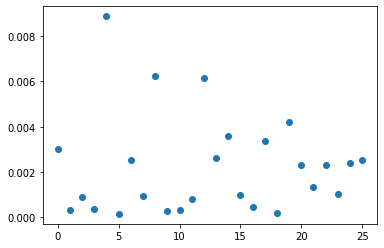

In [ ]:
plt.scatter(list(range(len(s))),s)

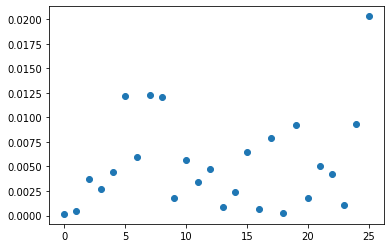

In [ ]:
plt.scatter(list(range(len(s))),s)

In [ ]:
encoder2=keras.models.load_model('/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_multiinput_slow_tr2.h5',custom_objects={'Sample':Sample,'KL_loss':KL_loss})

In [ ]:
X_enc2,_,_=encoder2(inputs)

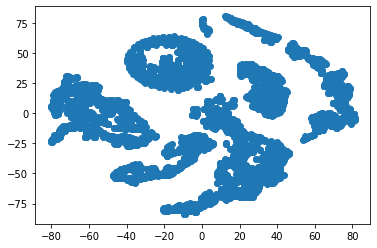

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc2)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

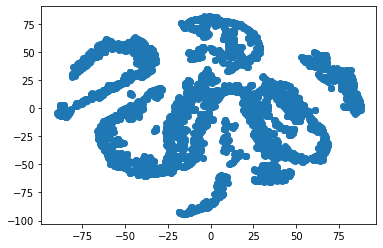

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

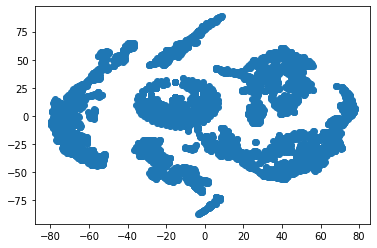

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

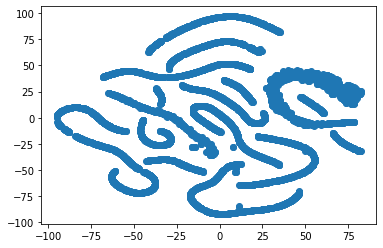

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

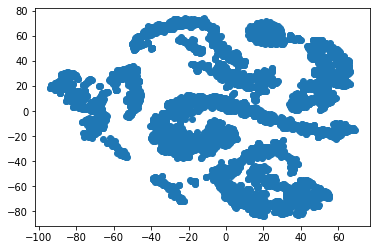

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

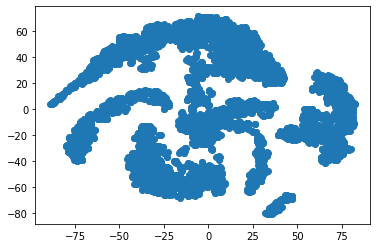

In [ ]:
from sklearn.manifold import TSNE
ts=TSNE(2)
X_2d2=ts.fit_transform(X_enc)
import matplotlib.pyplot as plt
plt.scatter(X_2d2[:,0],X_2d2[:,1])

In [ ]:
keras.models.save_model(vae,'/content/drive/MyDrive/0Thiland Coordination/AE Models/vae_multiinput_slow_tr4.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})
keras.models.save_model(encoder,'/content/drive/MyDrive/0Thiland Coordination/AE Models/encoder_multiinput_slow_tr4.h5',)#custom_objects={'Sample':Sample,'KL_loss':KL_loss})

## Visulization, Evalution and Expoloration

In [ ]:
from sklearn.cluster import AgglomerativeClustering,KMeans,AffinityPropagation

In [ ]:
for n_c in range(6,20):
  ag=AgglomerativeClustering(n_clusters=n_c,linkage='single')
  ag.fit(X_enc2)
  print(evaluate_clustering(X_enc2,ag.labels_))
  x,y=np.unique(ag.labels_,return_counts=True)
  print(y)

(0.50939256, 9388.3054645216)

<BarContainer object of 8 artists>

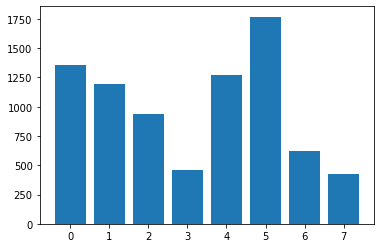

In [ ]:
plt.bar(x,y)

<BarContainer object of 8 artists>

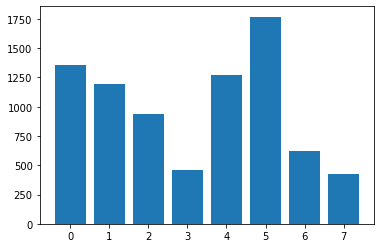

In [ ]:
#plot dis
plt.bar(x,y)

In [ ]:
idx_name={i:name for i,name in enumerate(df_all_cl2.index)}
name_idx={name:i for i,name in enumerate(df_all_cl2.index)}

In [ ]:
# plot dendogram
# code from here :https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_enc2,'ward')

labelList = range(len(X_2d2))

plt.figure(figsize=(10, 12))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

RecursionError: ignored

<Figure size 720x864 with 0 Axes>

In [ ]:
ag_model,clus_names,clus,=agg_clustering(X_2d2,8)

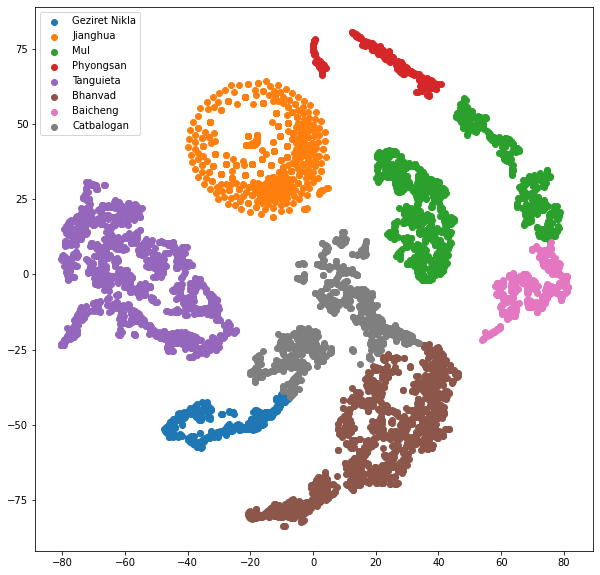

In [ ]:
viz_clusters(X_2d2,clus_names)

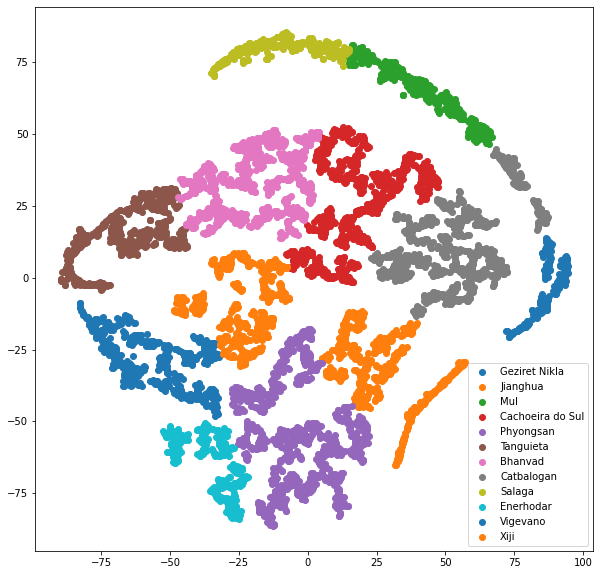

In [ ]:
viz_clusters(X_2d2,clus_names)

In [ ]:
#kmeans
clus_names,clus,=cluster_with_kmeans(X_2d2,8)

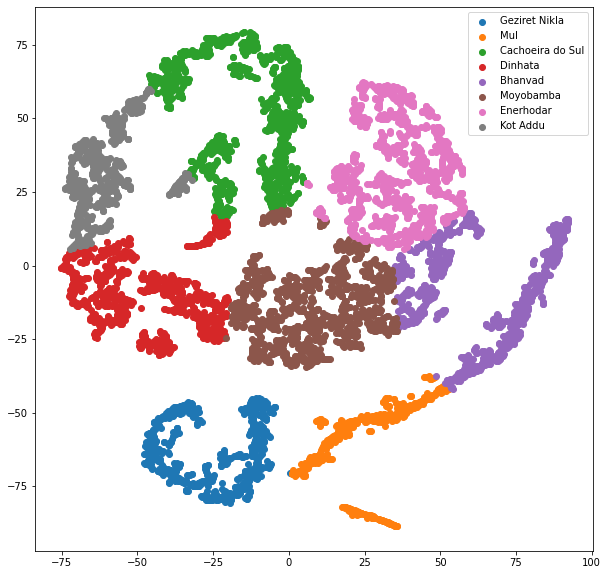

In [ ]:
viz_clusters(X_2d2,clus_names)

### Exploration


In [ ]:
def get_cluster_of(name,clus_dict):
  for k in clus_dict:
    if name in clus_dict[k]:
      return k

In [ ]:
def get_distance(pt1,pt2):
  return np.linalg.norm(pt1-pt2,axis=1)

In [ ]:
df_all_cl2.loc[['New York'],]-1

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                        ...                                
New York   -0.735307  -0.692302  ...       7.844333        24.019224

[1 rows x 52 columns]

In [ ]:
get_distance(X_enc2[mask],X_enc2[7418])[[7415,7416]]

array([0.00559136, 0.03379193], dtype=float32)

In [ ]:
get_distance(X_scaled[mask],X_scaled[7418])[[7415,7416]]

array([9.6768257 , 9.13506506])

In [ ]:
mask=np.ones(len(X_scaled),bool)
mask[7418]=False

In [ ]:
clus_names[1]

In [ ]:
get_cluster_of('New York',clus_names),get_cluster_of('Cairo',clus_names) ,get_cluster_of('Paris',clus_names) ,get_cluster_of('Minsk',clus_names),get_cluster_of('Vienna',clus_names),get_cluster_of('Khartoum',clus_names)

(1, 3, 7, 1, 7, 0)

In [ ]:
df_all_cl2.loc[['Cairo','Shanghai','Seoul']]

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                        ...                                
Cairo       0.143448   0.173402  ...       7.210669        20.778252
Shanghai    0.235692   0.322640  ...       7.098101        20.366177
Seoul       0.141745   0.185232  ...       9.253174        25.739544

[3 rows x 52 columns]

In [ ]:
df_all_cl2.loc[['Cairo','Minsk','New York'],]

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                        ...                                
Cairo       0.143448   0.173402  ...       7.210669        20.778252
Minsk       0.121951   0.147008  ...       7.664714        22.823355
New York    0.264693   0.307698  ...       8.844333        25.019224

[3 rows x 52 columns]

In [ ]:
def get_cluster_centers(df,clus_names):
  clus_means={}
  closest,furth={},{ }
  for k in clus_names:
    cluster_idx=clus_names[k]
    _clus_data=df.loc[cluster_idx]
    _mean=_clus_data.mean()
    dist=np.linalg.norm(_mean - _clus_data,axis=1)
    min_pt,max_pt=np.argmin(dist),np.argmax(dist)
    _min_c,max_c=_clus_data.loc[[cluster_idx[min_pt],]],_clus_data.loc[[cluster_idx[max_pt],]]
    closest[k]=_min_c.index.values[0]
    furth[k]=max_c.index.values[0]
    clus_means[k]=pd.DataFrame(_mean).transpose()
    
  
  return clus_means,closest,furth

    

In [ ]:
ms,cl,f=get_cluster_centers(df_all_cl2,clus_names)

In [ ]:
cluster_ana_dict={'means':ms,'closest':cl,'furthest':f}
pickle.dump(cluster_ana_dict,open('/content/drive/MyDrive/0Thiland Coordination/cluster_ana_dict.pkl','wb'))

In [ ]:
df_all_cl.loc[['Thul','Hyderabad']]

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                        ...                                
Thul        0.016261   0.024897  ...       7.481891        21.513100
Hyderabad   0.106687   0.176563  ...       2.694664        11.454657

[2 rows x 46 columns]

In [ ]:
df_all_cl2.sort_values('2015_area_change',ascending=False)

1990_area  2000_area  ...  stl1_2015_std  stl1_2015_range
eFUA_name                        ...                                
Haiyuan     0.000000   0.000246  ...       8.753084        24.847412
Agadez      0.000289   0.001322  ...       6.577769        19.720932
Guyuan      0.000034   0.001164  ...       8.029175        22.085276
Ibb         0.000425   0.001658  ...       1.718963         6.502220
Jingning    0.000123   0.001380  ...       8.019526        22.404350
...              ...        ...  ...            ...              ...
Hongya      0.022300   0.024551  ...       6.084808        17.085450
Nagqu       0.011821   0.014970  ...       5.405607        15.429001
Sogamoso    0.031945   0.031945  ...       0.423241         1.374349
Onne        0.087020   0.087339  ...       1.109844         2.838867
Hartishek   0.000000   0.022494  ...       1.245774         5.143265

[8025 rows x 52 columns]

In [ ]:
def plt_ranges_of_clusters(df,clus_names):
  pop_ls=['1990_Pop','2015_Pop']
  area_ls=['1990_area','2015_area']
  cl_ls=['CL2015','CL2020']
  st_ls=['stl1_1990_average','stl1_2015_average']
  ni_ls=['1990_mean','2015_mean']
  ni_med=['1990_median','2015_median']
  st_med=['stl1_1990_median','stl1_2015_median']
  area_ch=['2000_area_change','2015_area_change']


  plt_names={'population':pop_ls,'area':area_ls,'Area Change':area_ch,'citylight':cl_ls,'soil temp mean':st_ls,'soil temp median': st_med,'veg index mean':ni_ls,
             'veg index median': ni_med}

  for name in plt_names:
    for k in clus_names:
      _idx=clus_names[k]
      dt=df.loc[_idx,plt_names[name]].values
      plt.scatter(dt[:,0],dt[:,1])
    plt.title(name)
    plt.show()



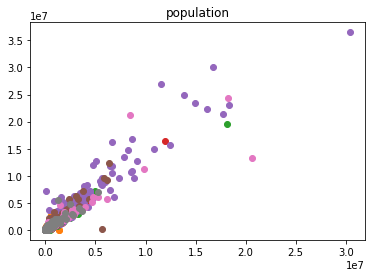

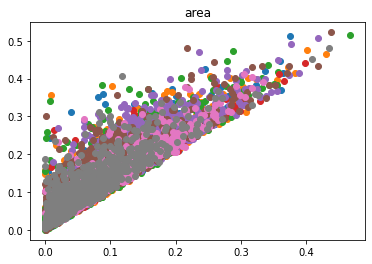

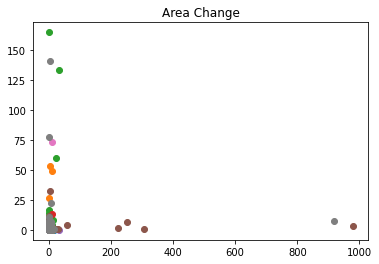

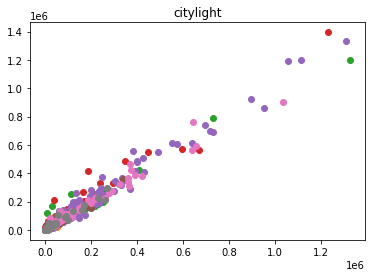

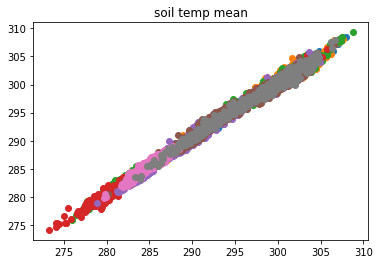

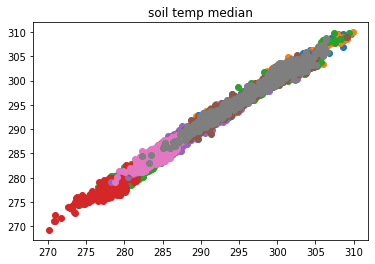

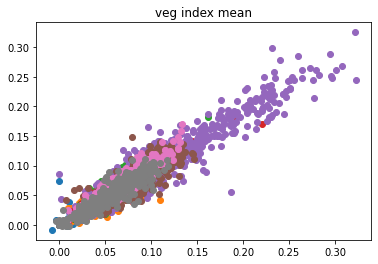

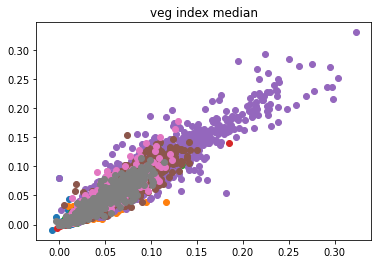

In [ ]:
plt_ranges_of_clusters(df_all_cl2,clus_names)

In [ ]:
import json
with open("/content/drive/MyDrive/0Thiland Coordination/clusters_names_st.json", "w",encoding='utf8') as outfile: 
    json.dump({int(k):clus_names[k] for k in clus_names }, outfile,ensure_ascii=False)


In [ ]:
# compare to direct input
ag_model,clus_names_dir,clus,=agg_clustering(X_scaled,8)

In [ ]:
evaluate_clustering(X_scaled,ag_model.labels_)

(0.18476878604109476, 970.8405065162093)

<BarContainer object of 8 artists>

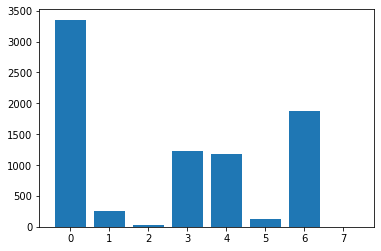

In [ ]:
x,y=np.unique(ag_model.labels_,return_counts=True)
plt.bar(x,y)

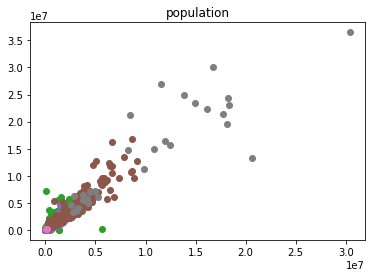

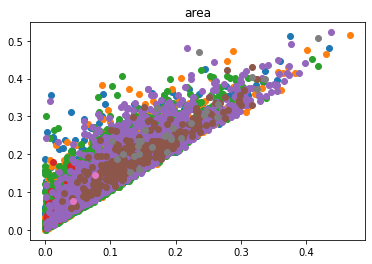

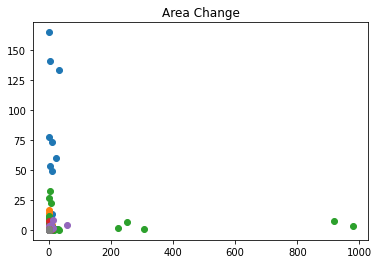

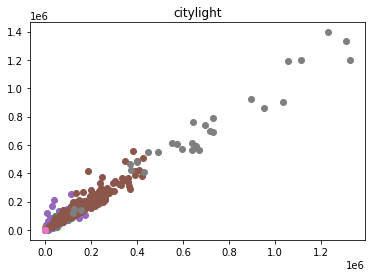

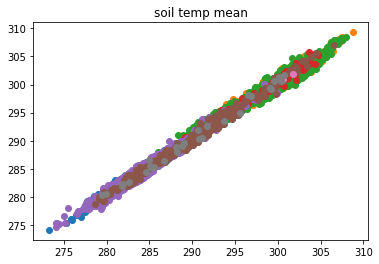

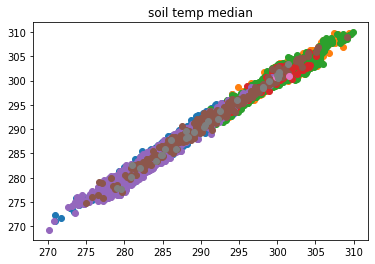

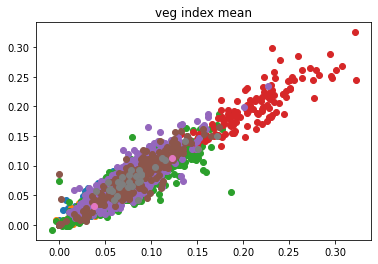

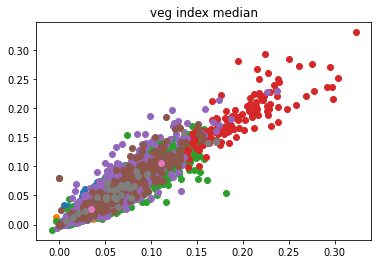

In [ ]:
plt_ranges_of_clusters(df_all_cl2,clus_names_dir)

In [ ]:
get_cluster_of('New York',clus_names_dir),get_cluster_of('Shanghai',clus_names_dir) ,get_cluster_of('Paris',clus_names_dir) ,get_cluster_of('Minsk',clus_names_dir),get_cluster_of('Vienna',clus_names_dir),get_cluster_of('Khartoum',clus_names_dir)

(2, 2, 2, 6, 1, 1)

In [ ]:
for k in clus_names_dir: print(k,len(clus_names_dir[k]))

4 1173
3 1223
0 3355
5 126
6 1869
1 248
7 2
2 29


In [ ]:
df_all_cl2.loc[:,['1990_Pop','2015_Pop']].sort_values('1990_Pop').iloc[0,].values

array([    0.        , 78345.64379883])

In [ ]:
def get_min_max_df(df,cols):
  mins=[]
  maxs=[]
  for col in cols:
    mins.append(df.loc[:,cols].sort_values(col).iloc[0,].values)
    maxs.append(df.loc[:,cols].sort_values(col,ascending=False).iloc[0,].values)
  
  return mins,maxs

In [ ]:
def plt_ranges_single_cluster(df,clus_names):
  pop_ls=['1990_Pop','2015_Pop']
  area_ls=['1990_area','2015_area']
  cl_ls=['CL2015','CL2020']
  st_ls=['stl1_1990_average','stl1_2015_average']
  ni_ls=['1990_mean','2015_mean']
  ni_med=['1990_median','2015_median']
  st_med=['stl1_1990_median','stl1_2015_median']
  area_ch=['2000_area_change','2015_area_change']


  plt_names={'population':pop_ls,'area':area_ls,'Area Change':area_ch,'citylight':cl_ls,'soil temp mean':st_ls,'soil temp median': st_med,'veg index mean':ni_ls,
             'veg index median': ni_med}


  for name in plt_names:
    for k in clus_names:
      _idx=clus_names[k]
      dt=df.loc[_idx,plt_names[name]].values
      plt.scatter(dt[:,0],dt[:,1])
      mins,maxs=get_min_max_df(df,plt_names[name])
      for m in mins:
        plt.scatter(m[0],m[1],marker='x')
      for m in maxs:
        plt.scatter(m[0],m[1],marker='x')
    plt.title(name)
    plt.show()



In [ ]:
def viz_specific_clusters(df,clus_names,clus_nums):
  n_cn={}
  for n in clus_nums:
    n_cn[n]=clus_names[n]
  
  rest=[]
  for k in clus_names:
    if k not in clus_nums:
      rest.append(clus_names[k])
  
  n_cn[11]=np.concatenate(rest)
  viz_clusters(df,n_cn)

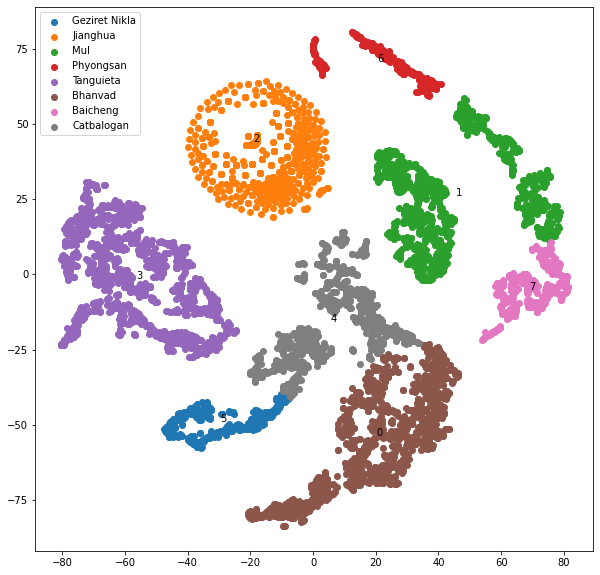

In [ ]:
viz_clusters(X_2d2,clus_names)

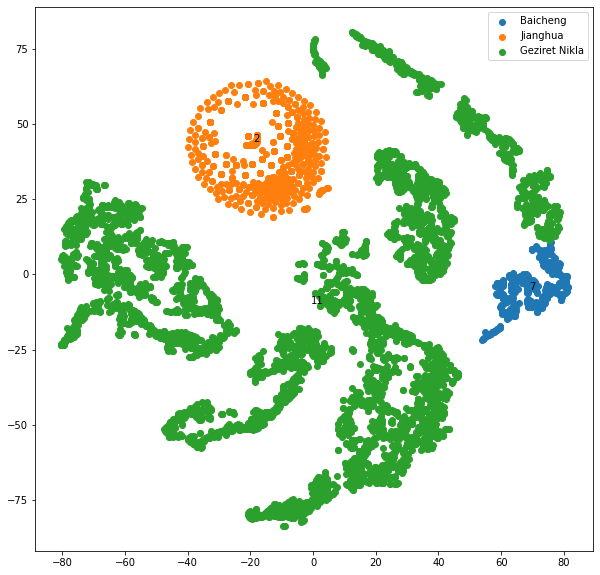

In [ ]:
viz_specific_clusters(X_2d2,clus_names,[7,2])

In [ ]:
|viz_specific_clusters(X_2d2,clus_names,[1,7])

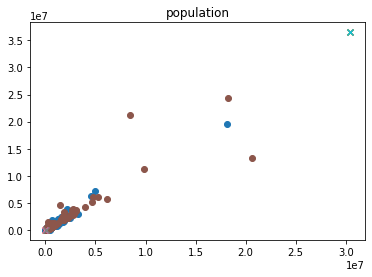

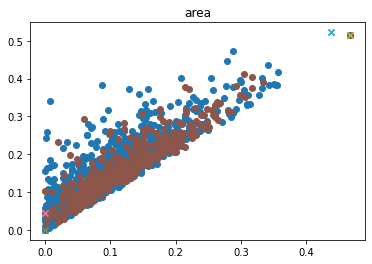

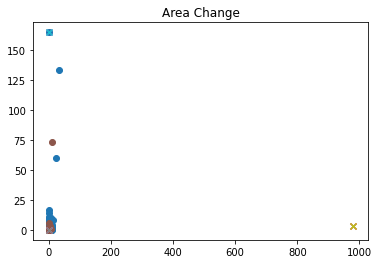

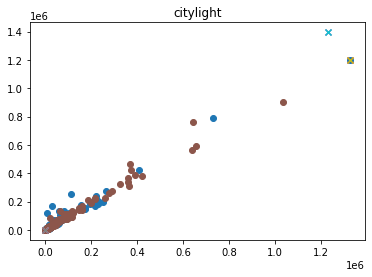

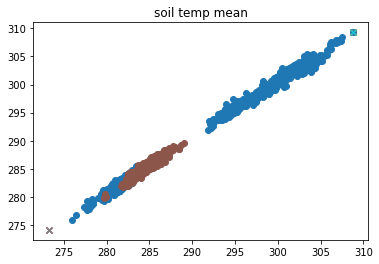

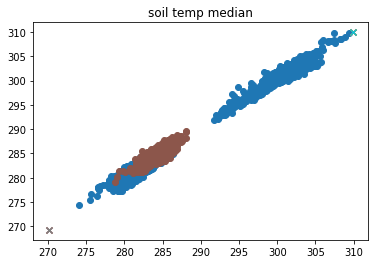

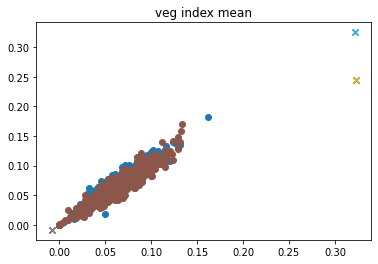

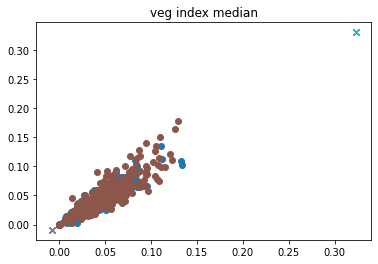

In [ ]:
# for one cluster (decision making intutoin)
plt_ranges_single_cluster(df_all_cl2,{1:clus_names[1],2:clus_names[7]})

In [ ]:
def tsne(X):
  ts=TSNE(2)
  X_2d=ts.fit_transform(X)
  return X_2d


In [ ]:
X_2d_dir=tsne(X_scaled)

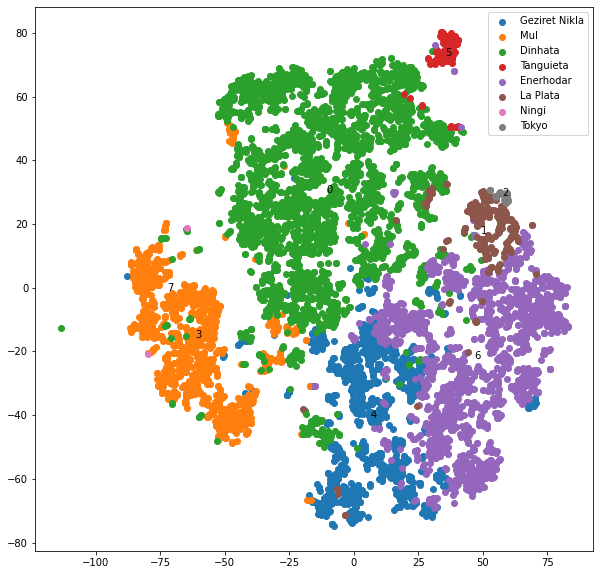

In [ ]:
viz_clusters(X_2d_dir,clus_names_dir)

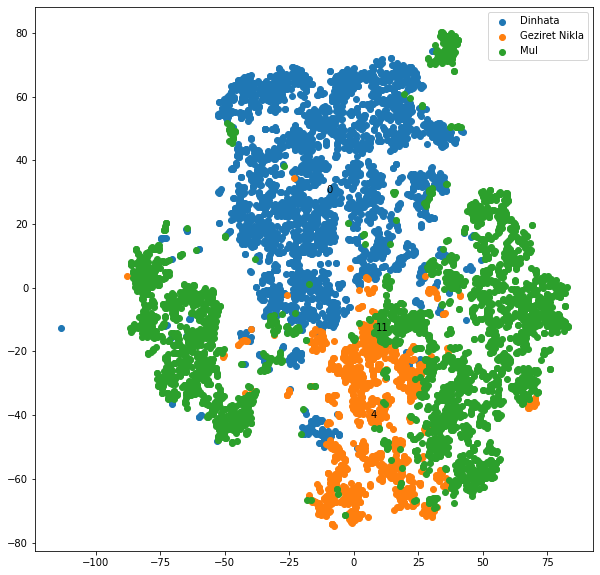

In [ ]:
viz_specific_clusters(X_2d_dir,clus_names_dir,[0,4])

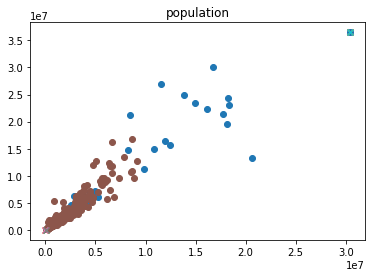

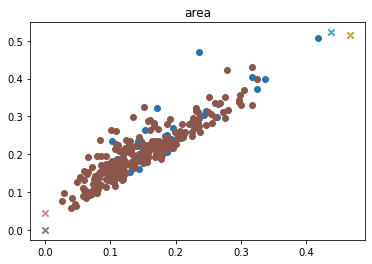

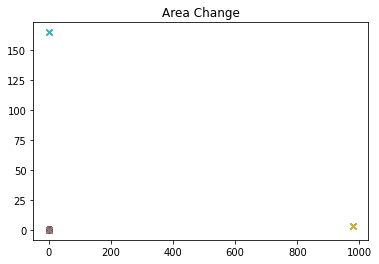

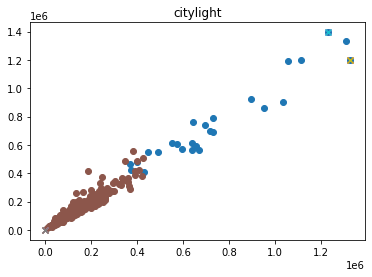

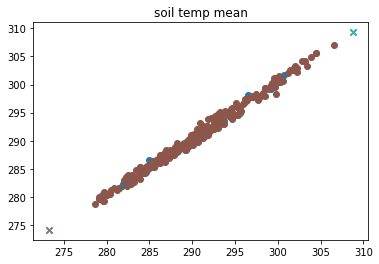

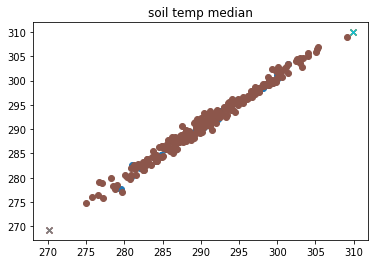

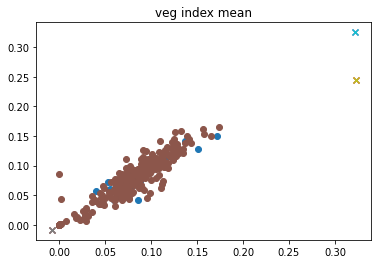

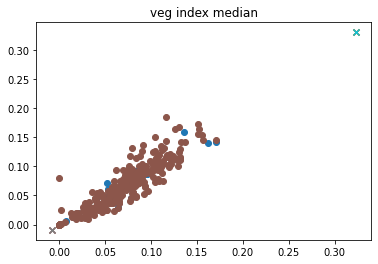

In [ ]:
plt_ranges_single_cluster(df_all_cl2,{2:clus_names_dir[2],3:clus_names_dir[1]})